In [ ]:
!nvidia-smi

Sat Feb 21 16:23:20 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   47C    P8             18W /  320W |    3477MiB /  16376MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 4080 SUPER


**Step 01 # Done Install the Ultralytics Package in the enviroment**

In [ ]:
from ultralytics import YOLO
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 4080 SUPER


**Step 02 # Import All the Requried Libraries**

In [ ]:
from ultralytics import YOLO
from IPython.display import Image

**Step # 03 Upload data set and unzip**

In [ ]:

import zipfile, shutil, random, os
from PIL import Image
from pathlib import Path

random.seed(42)

# ✅ Path
ZIP_PATH = r"C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\archive.zip"


zip_file = Path(ZIP_PATH)
assert zip_file.exists(), f"ZIP file not found: {zip_file}"


# ✅ Local folders
RAW_DIR  = Path("fer_raw")
YOLO_DIR = Path("dataset_yolo")

# Clean old folders
for p in [RAW_DIR, YOLO_DIR]:
    if p.exists():
        shutil.rmtree(p)

RAW_DIR.mkdir(parents=True, exist_ok=True)

# --- unzip ---
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(RAW_DIR)

print("✅ Unzipped to:", RAW_DIR.resolve())

# --- YOLO dataset structure ---
for split in ["train", "val", "test"]:
    (YOLO_DIR / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / "labels" / split).mkdir(parents=True, exist_ok=True)

classes = ["angry","disgust","fear","happy","neutral","sad","surprise"]
class_to_id = {c:i for i,c in enumerate(classes)}

def ensure_rgb(src_path: Path, dst_path: Path):
    img = Image.open(src_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    img.save(dst_path)

def write_label(dst_label_path: Path, class_id: int):
    dst_label_path.parent.mkdir(parents=True, exist_ok=True)
    dst_label_path.write_text(f"{class_id} 0.5 0.5 1.0 1.0\n")

val_ratio = 0.10

# train -> train/val split
for cls in classes:
    src_folder = RAW_DIR / "train" / cls
    img_paths = sorted([p for p in src_folder.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
    random.shuffle(img_paths)

    n_val = int(len(img_paths) * val_ratio)
    val_imgs = img_paths[:n_val]
    train_imgs = img_paths[n_val:]

    for p in train_imgs:
        dst_img = YOLO_DIR / "images" / "train" / p.name
        dst_lbl = YOLO_DIR / "labels" / "train" / f"{p.stem}.txt"
        ensure_rgb(p, dst_img)
        write_label(dst_lbl, class_to_id[cls])

    for p in val_imgs:
        dst_img = YOLO_DIR / "images" / "val" / p.name
        dst_lbl = YOLO_DIR / "labels" / "val" / f"{p.stem}.txt"
        ensure_rgb(p, dst_img)
        write_label(dst_lbl, class_to_id[cls])

# test
for cls in classes:
    src_folder = RAW_DIR / "test" / cls
    img_paths = sorted([p for p in src_folder.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])

    for p in img_paths:
        dst_img = YOLO_DIR / "images" / "test" / p.name
        dst_lbl = YOLO_DIR / "labels" / "test" / f"{p.stem}.txt"
        ensure_rgb(p, dst_img)
        write_label(dst_lbl, class_to_id[cls])

# data.yaml
yaml_text = f"""path: {YOLO_DIR.resolve()}
train: images/train
val: images/val
test: images/test

nc: {len(classes)}
names: {classes}
"""
(YOLO_DIR / "data.yaml").write_text(yaml_text)
print("✅ Wrote:", (YOLO_DIR / "data.yaml").resolve())
print(yaml_text)

import glob
print("Train images:", len(glob.glob("dataset_yolo/images/train/*")))
print("Val images:", len(glob.glob("dataset_yolo/images/val/*")))
print("Test images:", len(glob.glob("dataset_yolo/images/test/*")))
print("Train labels:", len(glob.glob("dataset_yolo/labels/train/*")))

✅ Unzipped to: C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\fer_raw
✅ Wrote: C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\data.yaml
path: C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo
train: images/train
val: images/val
test: images/test

nc: 7
names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Train images: 25839
Val images: 2868
Test images: 7178
Train labels: 25839


**Step # 04 Train YOLO11 Model on a Custom Dataset**

In [ ]:
from ultralytics import YOLO
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

model = YOLO("yolo11n.pt")

results = model.train(
    data="dataset_yolo/data.yaml",
    epochs=50,
    imgsz=96,
    batch=128,
    device=0,      # ✅ force GPU
    project="runs",# ✅ saves into ./runs/detect/...
    name="fer_fullbox",
    plots=True
)

print("✅ Training done. Saved to: runs/detect/fer_fullbox (or fer_fullbox2 if rerun)")

CUDA available: True
GPU: NVIDIA GeForce RTX 4080 SUPER
Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=96, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=fer_fullbox, nbs=64, nms=False, opset=None, optim

**Step # 05 Examine Training Results**

Using: runs/detect/runs\fer_fullbox


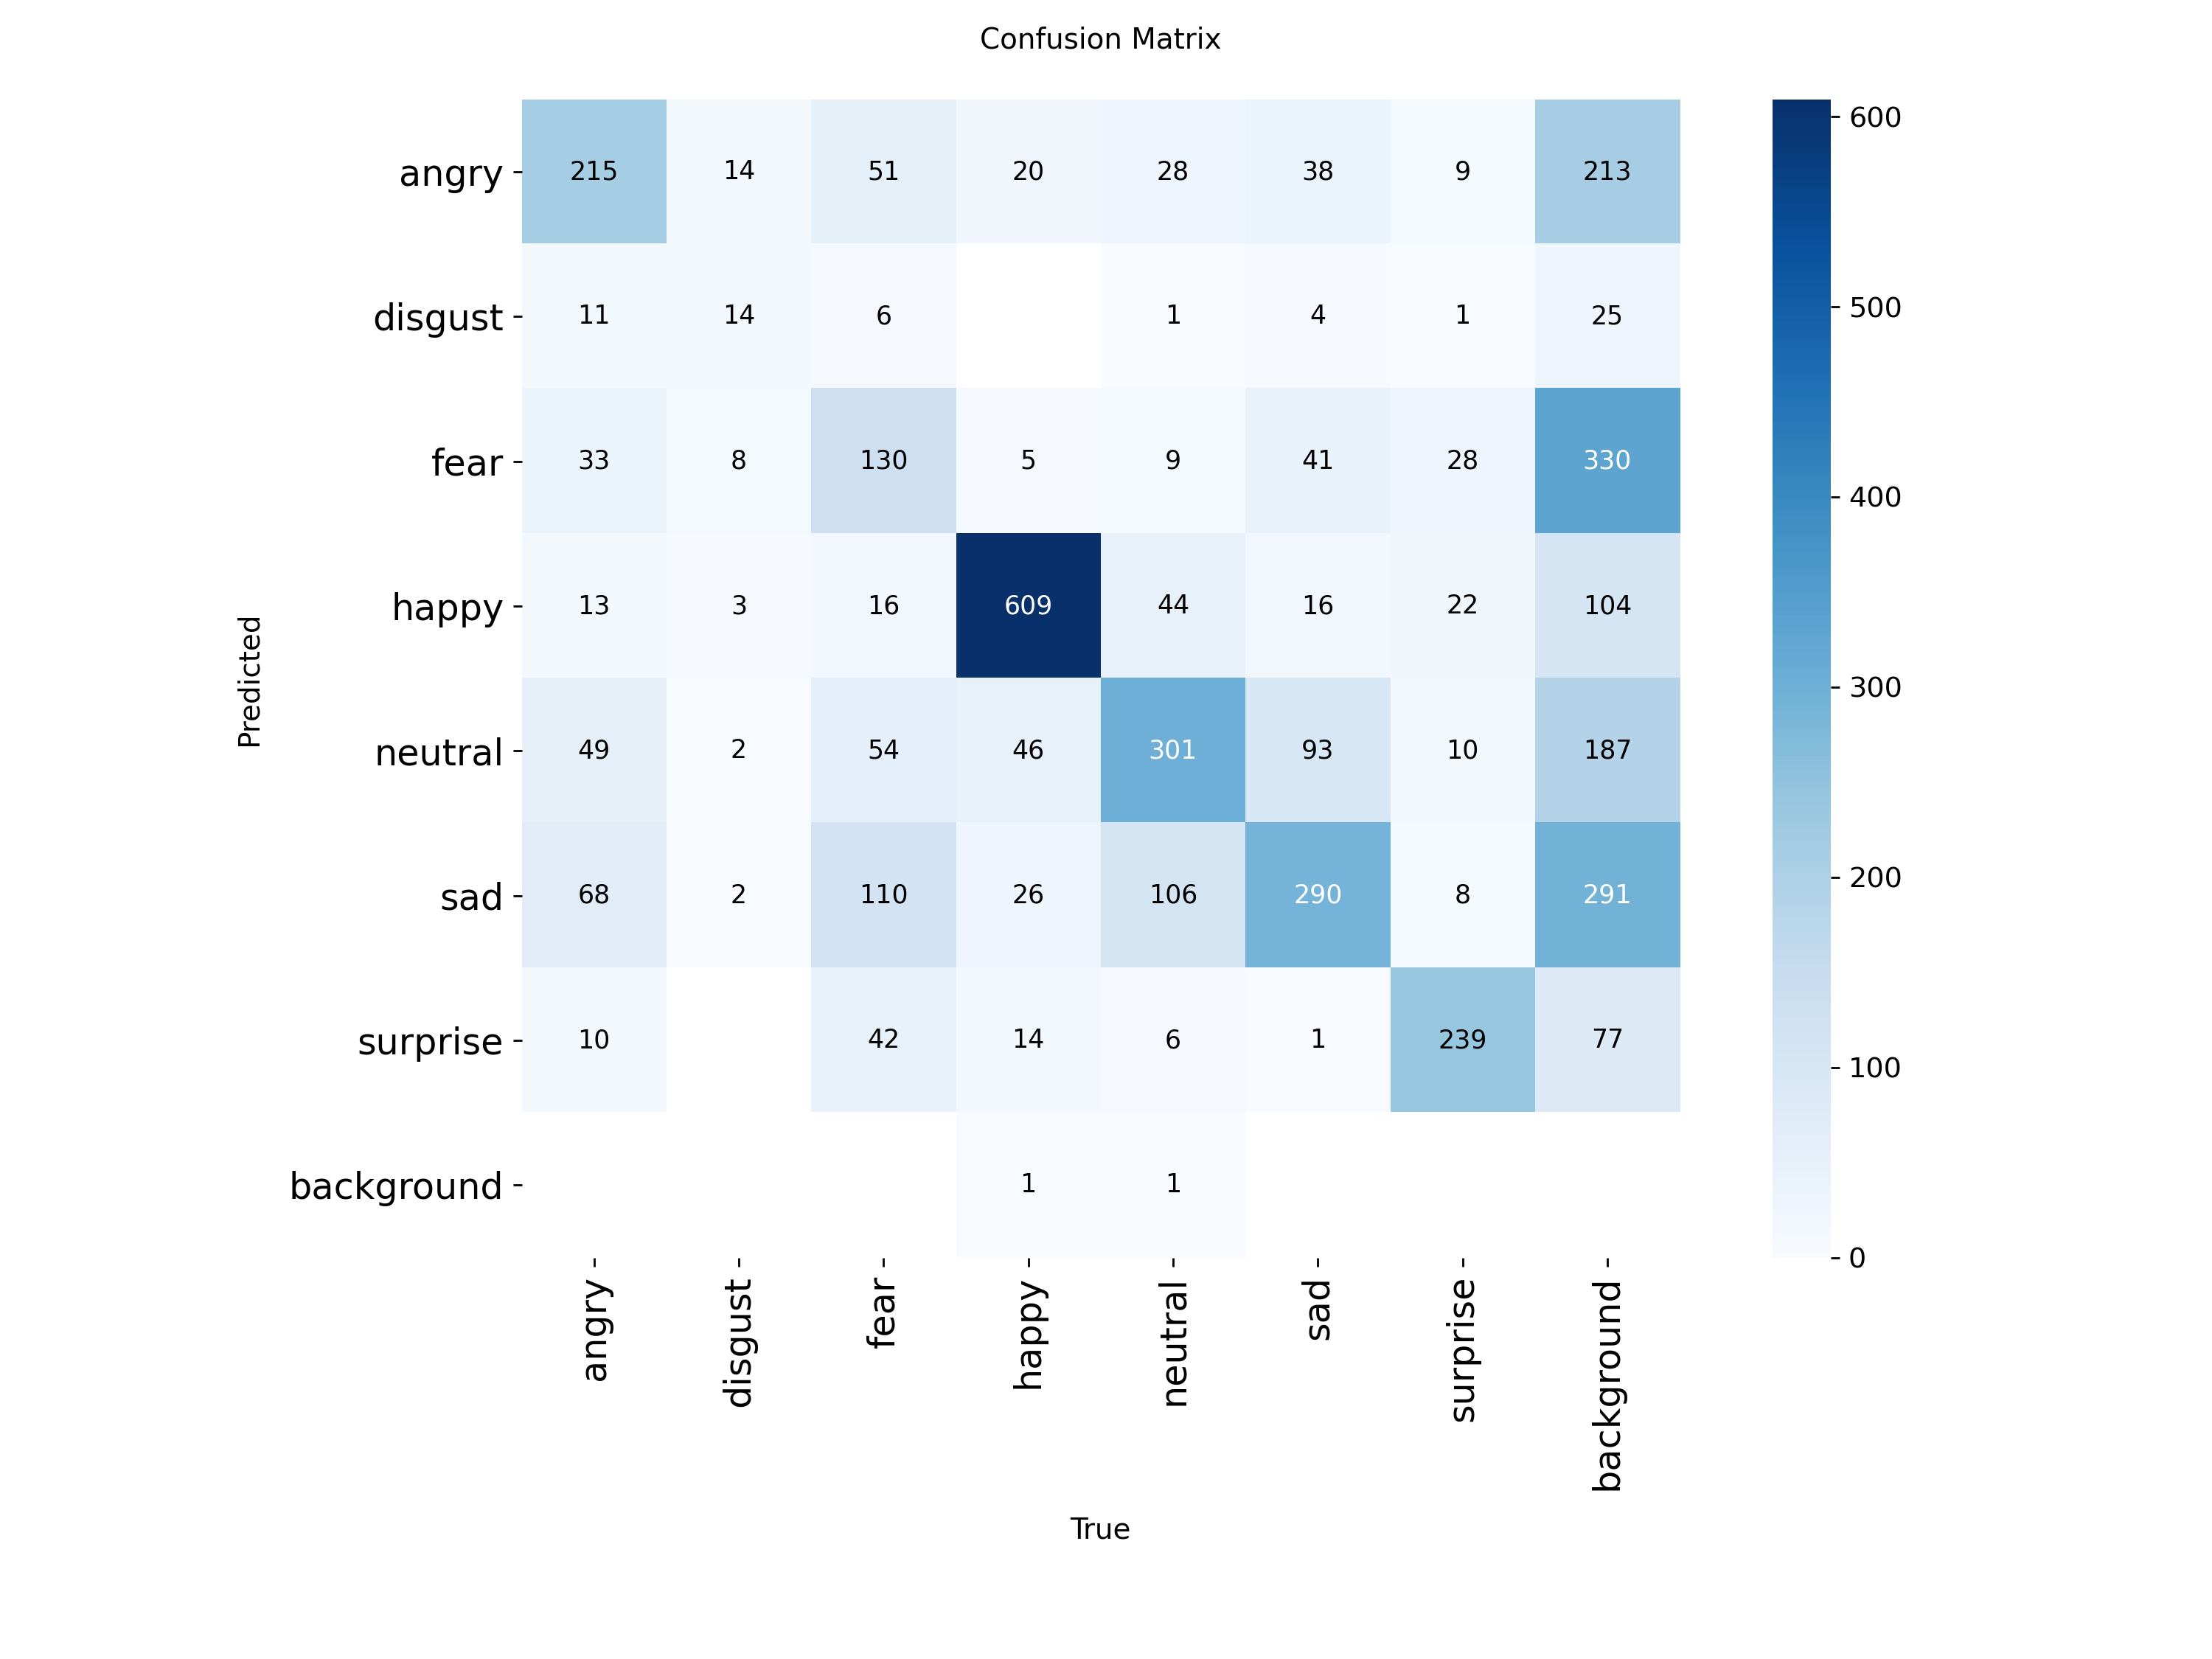

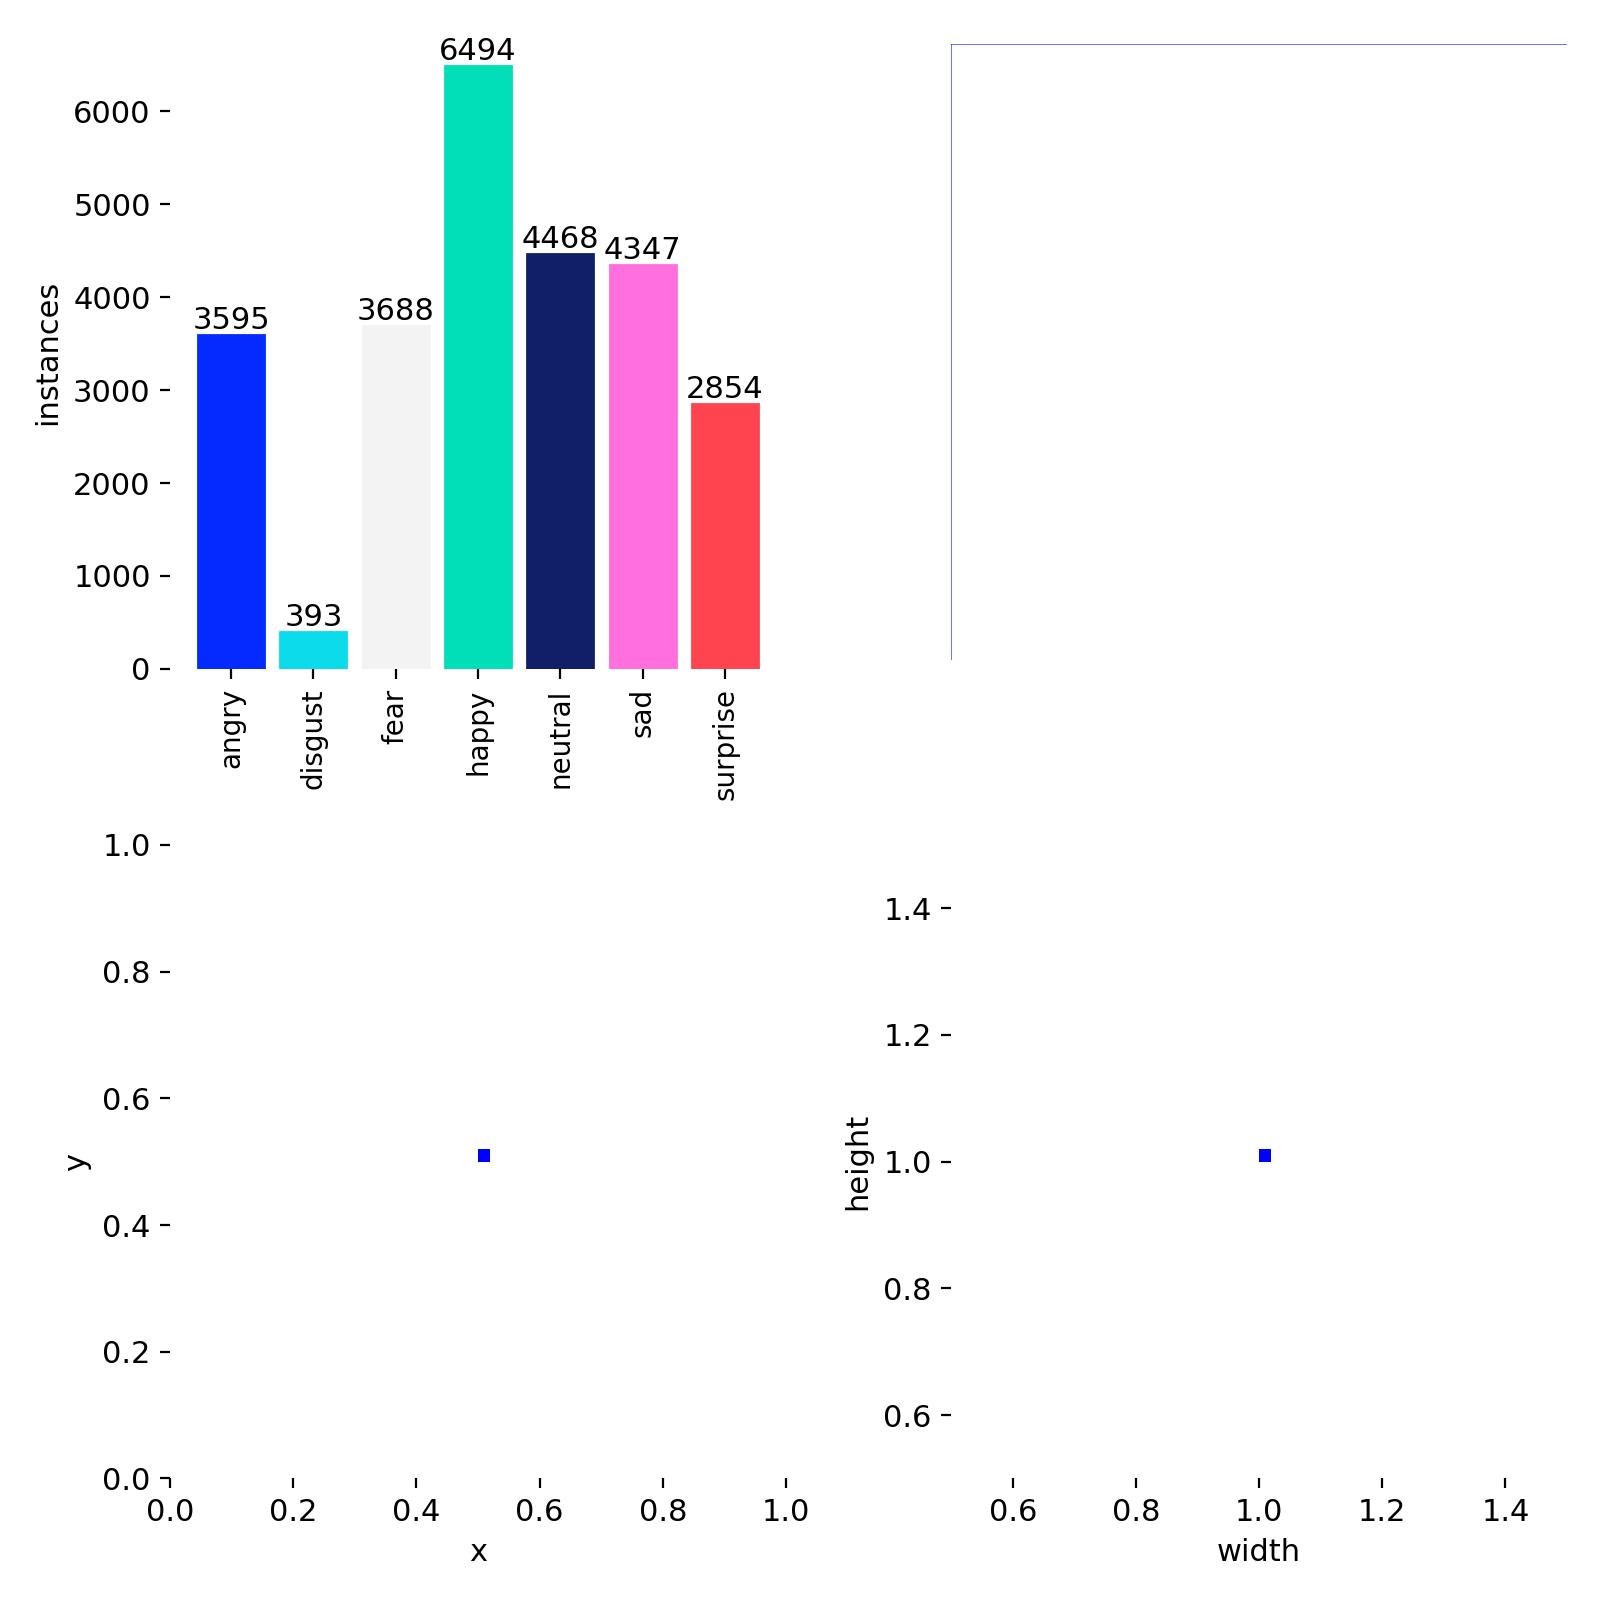

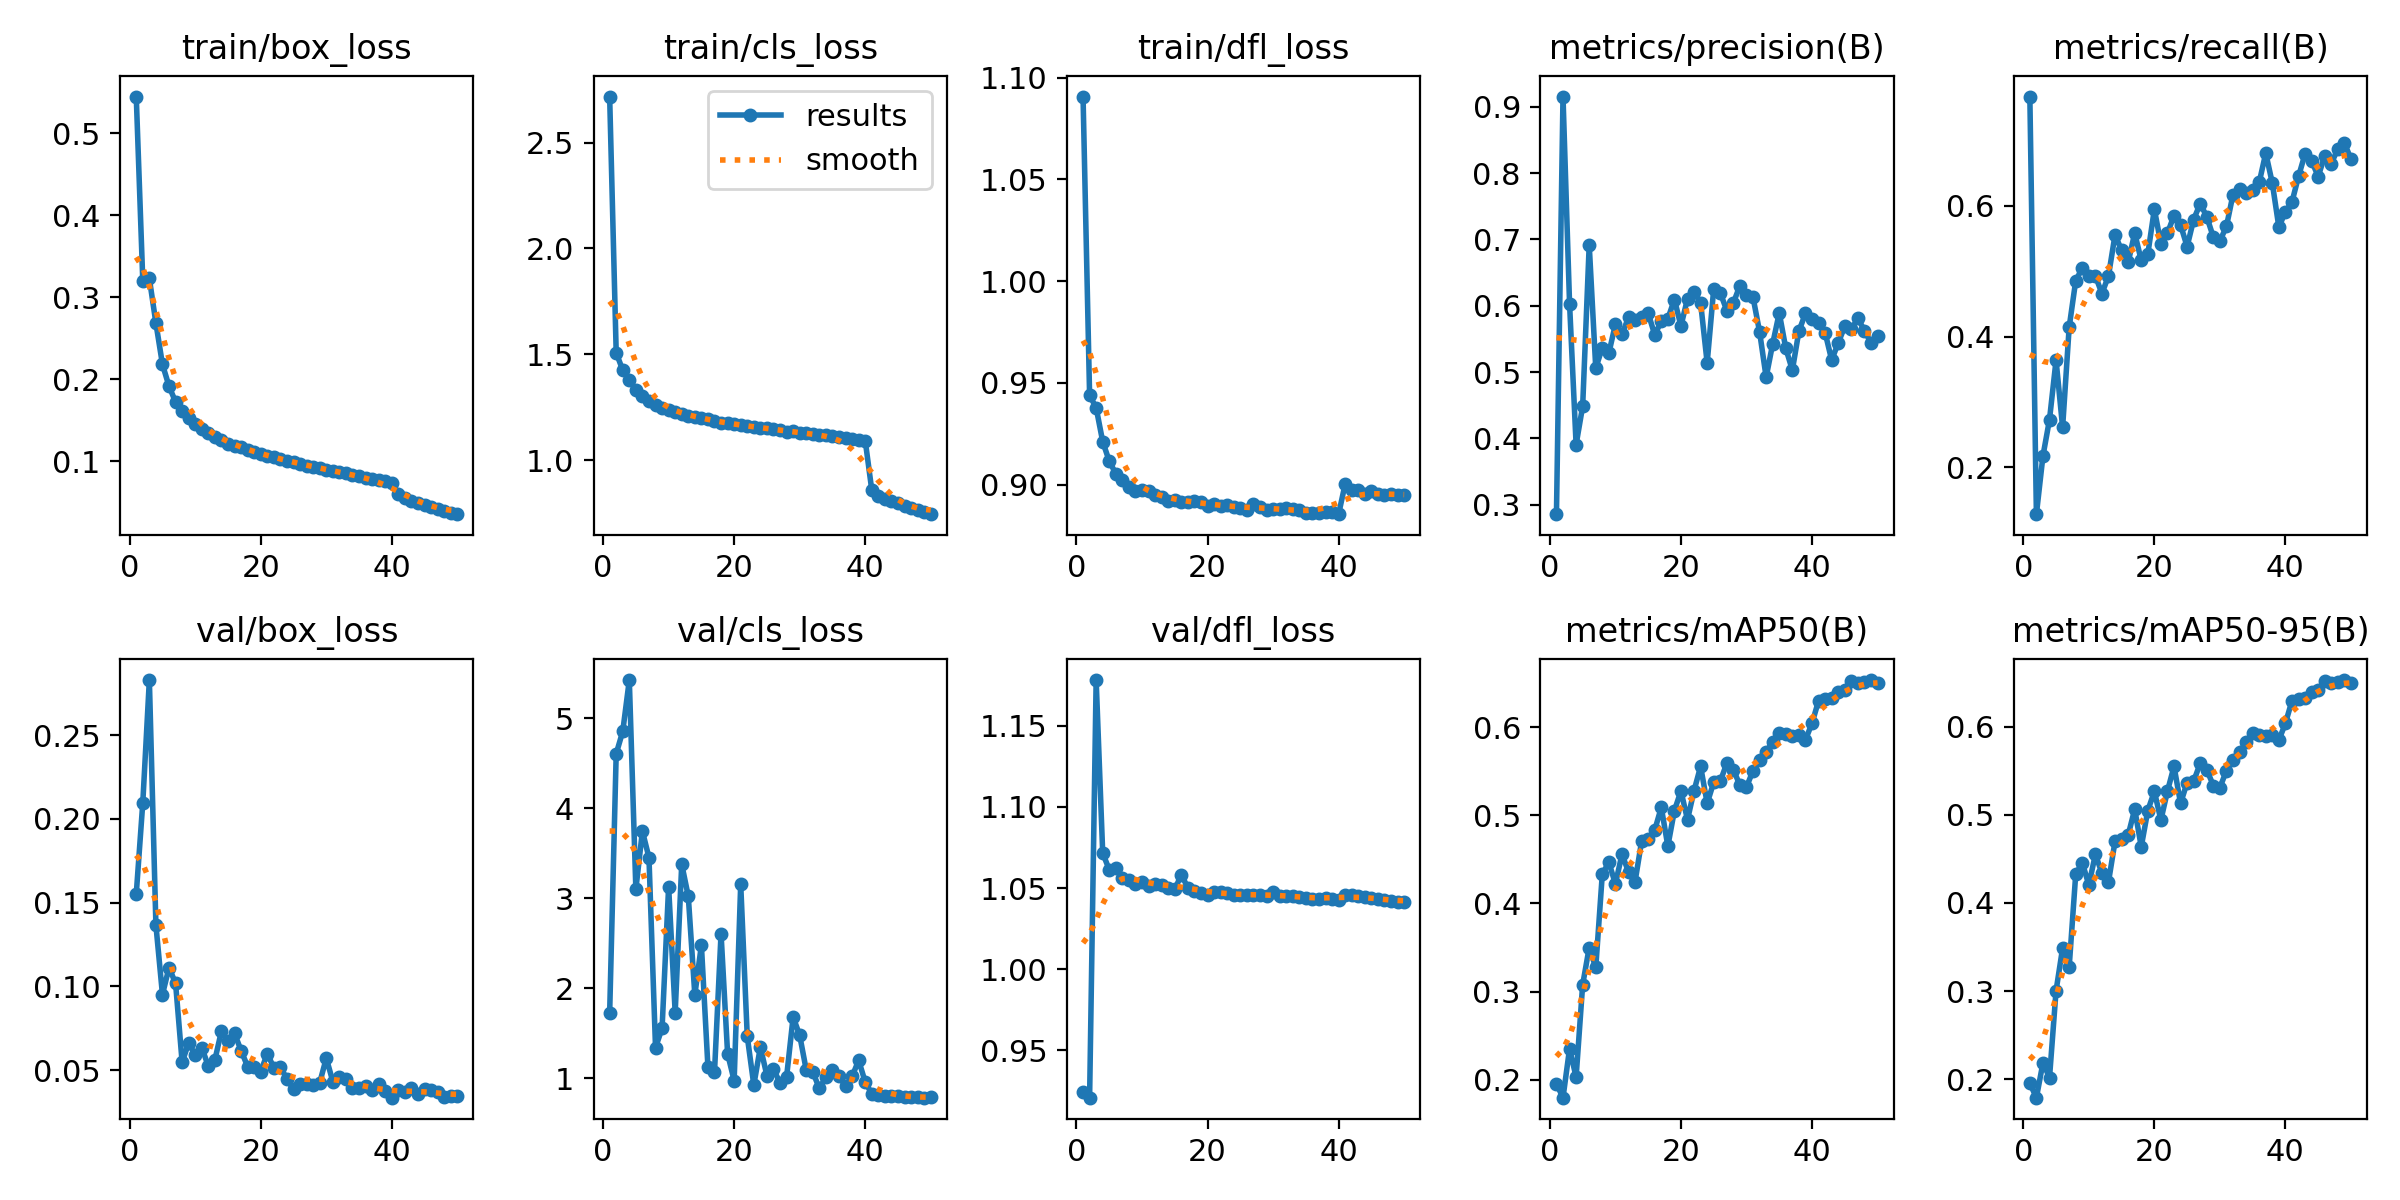

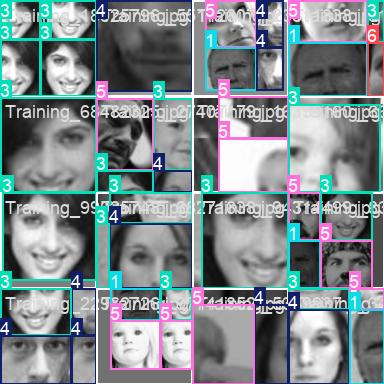

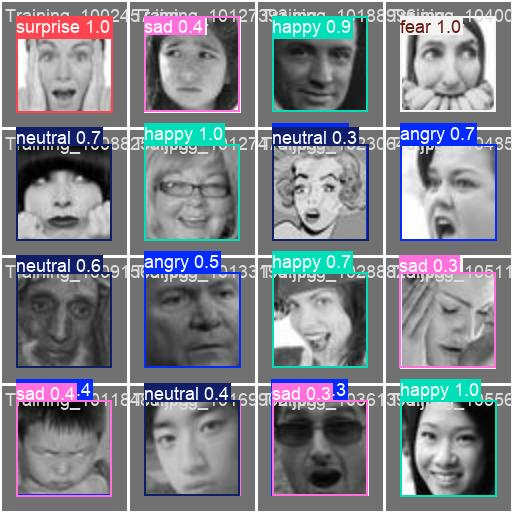

In [ ]:
import glob, os
from IPython.display import Image as IPyImage, display


runs = glob.glob("runs/detect/runs/fer_fullbox*")

if not runs:
    print("No fer_fullbox runs found in runs/detect/runs/")
    print("Found these folders instead:", glob.glob("runs/**", recursive=True)[:50])
else:
    train_dir = max(runs, key=os.path.getmtime)
    print("Using:", train_dir)

    for f in ["confusion_matrix.png", "labels.jpg", "results.png", "train_batch0.jpg", "val_batch0_pred.jpg"]:
        path = os.path.join(train_dir, f)
        if os.path.exists(path):
            display(IPyImage(filename=path, width=700))
        else:
            print("Missing:", path)

**Step # 07  Validate Fine-Tuned Model**

In [ ]:
import glob, os
from ultralytics import YOLO


runs = glob.glob("runs/detect/runs/fer_fullbox*")

if not runs:
    raise FileNotFoundError("No fer_fullbox runs found in runs/detect/runs/")

RUN_DIR = max(runs, key=os.path.getmtime)
BEST_PT = os.path.join(RUN_DIR, "weights", "best.pt")

print("Using RUN_DIR:", RUN_DIR)
print("Using BEST_PT:", BEST_PT)

# load trained model
model = YOLO(BEST_PT)

# validate
metrics = model.val(
    data="dataset_yolo/data.yaml",
    plots=True
)

print("Validation complete.")

Using RUN_DIR: runs/detect/runs\fer_fullbox
Using BEST_PT: runs/detect/runs\fer_fullbox\weights\best.pt
Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 8.71.9 MB/s, size: 1.1 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 14.0it/s 12.9s0.1s
                   all       2868       2868      0.544      0.696      0.653      0.653
                 angry        399        399      0.506       0.69      0.626      0.626
               disgust         43         43      0.331      0.419      0.401      0.401
                  fear        409        

In [ ]:
from ultralytics import YOLO
import pandas as pd

# ✅ Load BASELINE model
model = YOLO("runs/detect/runs/fer_fullbox/weights/best.pt")

# ✅ Validate using same dataset
metrics = model.val(data="dataset_yolo/data.yaml")

# Get class names
names = metrics.names

# Extract per-class metrics
p = metrics.box.p
r = metrics.box.r
ap50 = metrics.box.ap50
ap = metrics.box.ap

# Build table
rows = []
for i, name in names.items():
    rows.append({
        "Class": name,
        "Precision": float(p[i]),
        "Recall": float(r[i]),
        "mAP50": float(ap50[i]),
        "mAP50-95": float(ap[i]),
        "F1": float(2 * p[i] * r[i] / (p[i] + r[i] + 1e-16))
    })

df_baseline = pd.DataFrame(rows).sort_values("Class")

print(df_baseline)

# Save file
df_baseline.to_csv("per_class_metrics_baseline.csv", index=False)

print("\nSaved as per_class_metrics_baseline.csv")

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 13.64.2 MB/s, size: 1.3 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 14.1it/s 12.7s0.1s
                   all       2868       2868      0.544      0.696      0.653      0.653
                 angry        399        399      0.506       0.69      0.626      0.626
               disgust         43         43      0.331      0.419      0.401      0.401
                  fear        409        409       0.46      0.545      0.517      0.517
                 happy        721        721       0.81

In [ ]:
pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 4.2 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.1 MB 4.2 MB/s eta 0:00:02
   ------------ --------------------------- 2.6/8.1 MB 4.6 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 4.1 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 3.8 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 3.5 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 3.5 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.1 MB 3.9 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 4.0 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 3.9 MB/s  0:00:02
Using cached threadpoolctl-3.

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# -----------------------
# Load Model
# -----------------------
model = YOLO("runs/detect/runs/fer_fullbox/weights/best.pt")

# -----------------------
# Dataset Paths
# -----------------------
DATA_ROOT  = Path(r"C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo")
VAL_IMAGES = DATA_ROOT / "images" / "val"
VAL_LABELS = DATA_ROOT / "labels" / "val"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

y_true = []
y_pred = []

# -----------------------
# Read Ground Truth
# -----------------------
def read_gt_class(label_path):
    if not label_path.exists():
        return None
    lines = label_path.read_text().strip().splitlines()
    if not lines:
        return None
    return int(lines[0].split()[0])  # first value = class id

# -----------------------
# Loop Through Validation Images
# -----------------------
for img_path in VAL_IMAGES.iterdir():
    if img_path.suffix.lower() not in IMG_EXTS:
        continue

    label_path = VAL_LABELS / f"{img_path.stem}.txt"
    gt_class = read_gt_class(label_path)

    if gt_class is None:
        continue

    results = model.predict(str(img_path), verbose=False)
    boxes = results[0].boxes

    # If no detection → treat as wrong prediction (-1 or skip)
    if boxes is None or len(boxes) == 0:
        continue

    confs = boxes.conf.cpu().numpy()
    classes = boxes.cls.cpu().numpy()
    best_idx = np.argmax(confs)
    pred_class = int(classes[best_idx])

    y_true.append(gt_class)
    y_pred.append(pred_class)

# -----------------------
# Compute Metrics
# -----------------------
accuracy = accuracy_score(y_true, y_pred)
print("Baseline model yolo11n:\n")
print(f"\nAccuracy: {accuracy:.4f}\n")

print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(model.names.values())
))

Baseline model yolo11n:


Accuracy: 0.6611

Classification Report:

              precision    recall  f1-score   support

       angry       0.59      0.64      0.61       399
     disgust       0.77      0.23      0.36        43
        fear       0.58      0.36      0.44       408
       happy       0.83      0.87      0.85       721
     neutral       0.55      0.74      0.63       495
         sad       0.56      0.53      0.54       482
    surprise       0.80      0.75      0.77       317

    accuracy                           0.66      2865
   macro avg       0.67      0.59      0.60      2865
weighted avg       0.66      0.66      0.65      2865



**Step # 08 Inference with Custom Model on Images**

In [ ]:
import glob, os
from ultralytics import YOLO

# find your already trained model
runs = glob.glob("runs/detect/runs/fer_fullbox*")

if not runs:
    raise FileNotFoundError("No fer_fullbox runs found in runs/detect/runs/")

RUN_DIR = max(runs, key=os.path.getmtime)
BEST_PT = os.path.join(RUN_DIR, "weights", "best.pt")

TEST_SOURCE = "dataset_yolo/images/test"

print("Using RUN_DIR:", RUN_DIR)
print("Using BEST_PT:", BEST_PT)
print("Using TEST_SOURCE:", TEST_SOURCE)

# load model
model = YOLO(BEST_PT)

# run prediction
results = model.predict(
    source=TEST_SOURCE,
    conf=0.25,
    save=True
)

print("Inference complete.")

Using RUN_DIR: runs/detect/runs\fer_fullbox
Using BEST_PT: runs/detect/runs\fer_fullbox\weights\best.pt
Using TEST_SOURCE: dataset_yolo/images/test

WARNING 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/7178 c:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\images\test\PrivateTest_10072988.jpg: 96x96 1 surprise, 10.2ms
image 2/7178 c:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\images\test\PrivateTest_10077120.jpg: 96x96 1 happy,

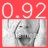

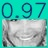

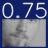

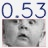

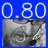

In [ ]:
#Show predicitons
import glob
from IPython.display import Image, display

pred_imgs = glob.glob("runs/detect/predict/*.jpg")

for img in pred_imgs[:5]:  # show first 5
    display(Image(filename=img, width=600))

In [ ]:
#Loss over epochs
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_loss(exp_path, title=None):
    exp_path = Path(exp_path)
    df = pd.read_csv(exp_path / "results.csv")

    train_loss = df["train/box_loss"] + df["train/cls_loss"] + df["train/dfl_loss"]
    val_loss   = df["val/box_loss"]   + df["val/cls_loss"]   + df["val/dfl_loss"]

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(df["epoch"], train_loss, label="Training Loss")
    ax.plot(df["epoch"], val_loss, label="Validation Loss")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(title if title else f"Loss Curve - {exp_path.name}")
    ax.legend()
    ax.grid(True)

    fig.savefig(exp_path / "loss_curve.png", dpi=200, bbox_inches="tight")

    plt.show()   # <- this is what VSCode usually respects

In [ ]:
plot_loss("runs/detect/runs/fer_fullbox", "Baseline Model")

<Figure size 800x500 with 1 Axes>

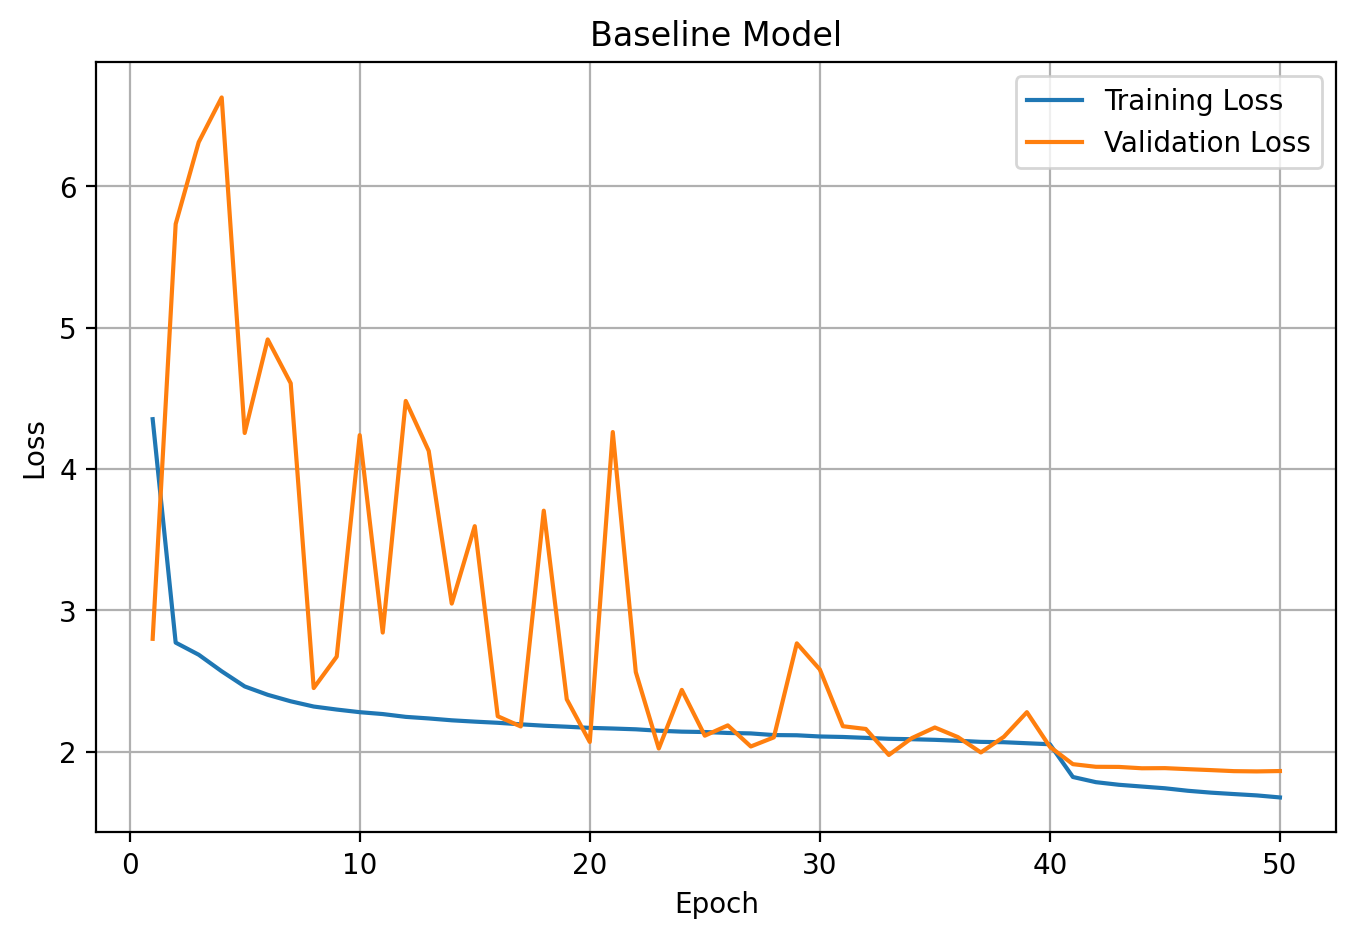

In [ ]:
from IPython.display import Image, display
display(Image("runs/detect/runs/fer_fullbox/loss_curve.png"))

In [ ]:
# Metrics over epochs
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_metrics(exp_path, title=None):
    exp_path = Path(exp_path)
    df = pd.read_csv(exp_path / "results.csv")

    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
    ax.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
    ax.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50")

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Metric Value")
    ax.set_title(title if title else f"Metrics Curve - {exp_path.name}")
    ax.legend()
    ax.grid(True)

    fig.savefig(exp_path / "metrics_curve.png", dpi=200, bbox_inches="tight")

    plt.show()

<Figure size 800x500 with 1 Axes>

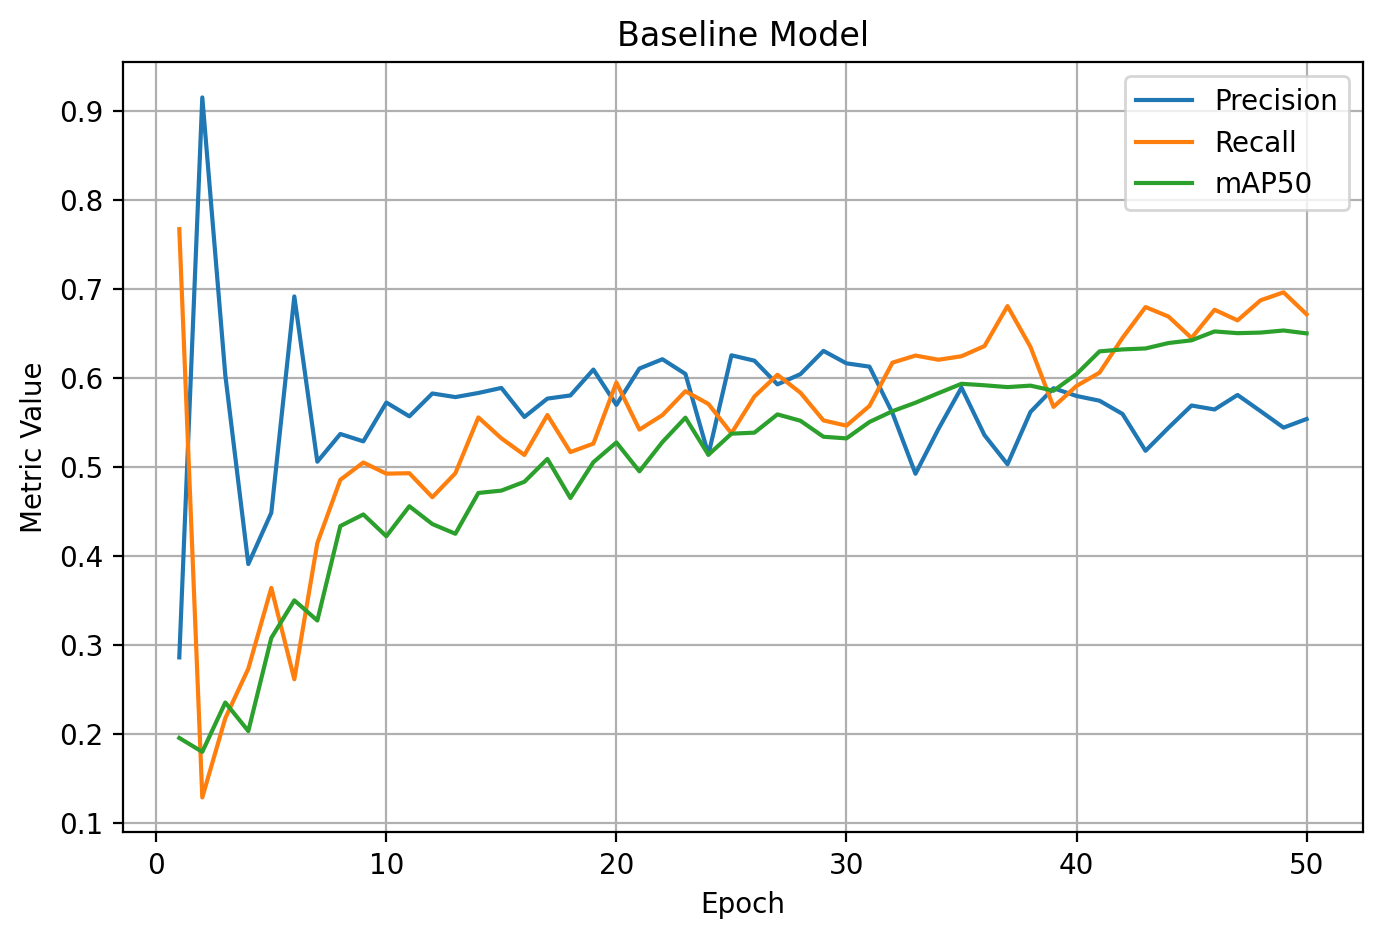

In [ ]:
plot_metrics("runs/detect/runs/fer_fullbox", "Baseline Model")
display(Image("runs/detect/runs/fer_fullbox/metrics_curve.png"))

Step 09 — Improvements / Experiments

baseline numbers

Baseline model: yolo11n

imgsz: 96

epochs: 50

mAP50 (all): 0.653

Worst class: disgust (0.401)

In [ ]:
project="runs_exp"

Improvement 1: Larger Model (YOLO11s)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11s.pt")

model.train(
    data="dataset_yolo/data.yaml",
    epochs=50,
    imgsz=96,
    batch=128,
    device=0,
    project="runs_exp",
    name="exp1_yolo11s",
    plots=True
)

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=96, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=exp1_yolo11s3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002091C620A50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [ ]:
from ultralytics import YOLO
import pandas as pd

# ✅ Load your trained model
model = YOLO("runs/detect/runs_exp/exp1_yolo11s3/weights/best.pt")

# ✅ Run validation (make sure data.yaml path is correct)
metrics = model.val(data="dataset_yolo/data.yaml")

# ✅ Get class names
names = metrics.names

# ✅ Extract per-class metrics
p = metrics.box.p
r = metrics.box.r
ap50 = metrics.box.ap50
ap = metrics.box.ap

# ✅ Build table
rows = []
for i, name in names.items():
    rows.append({
        "Class": name,
        "Precision": float(p[i]),
        "Recall": float(r[i]),
        "mAP50": float(ap50[i]),
        "mAP50-95": float(ap[i]),
        "F1": float(2 * p[i] * r[i] / (p[i] + r[i] + 1e-16))
    })

df = pd.DataFrame(rows).sort_values("Class")

# ✅ Display table
print(df)

# ✅ Save to CSV
df.to_csv("per_class_metrics_epx1.csv", index=False)

print("\nSaved as per_class_metrics_exp1.csv")

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11s summary (fused): 101 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 14.42.5 MB/s, size: 1.2 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 12.8it/s 14.1s0.2s
                   all       2868       2868      0.608      0.709      0.714      0.714
                 angry        399        399      0.576      0.667      0.671      0.671
               disgust         43         43      0.553      0.605       0.67       0.67
                  fear        409        409      0.466      0.548      0.559      0.559
                 happy        721        721      0.84

In [ ]:
import glob, os
from ultralytics import YOLO

runs = glob.glob("runs/**/exp1_yolo11s*", recursive=True)

if not runs:
    raise FileNotFoundError("No exp1_yolo11s run found anywhere under runs/")

RUN_DIR = max(runs, key=os.path.getmtime)
BEST_PT = os.path.join(RUN_DIR, "weights", "best.pt")

print("Found:", RUN_DIR)

model = YOLO(BEST_PT)
model.val(data="dataset_yolo/data.yaml", plots=True)

Found: runs\detect\runs_exp\exp1_yolo11s3
Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11s summary (fused): 101 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 9.72.2 MB/s, size: 1.1 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 14.5it/s 12.4s0.1s
                   all       2868       2868      0.608      0.709      0.714      0.714
                 angry        399        399      0.576      0.667      0.671      0.671
               disgust         43         43      0.553      0.605       0.67       0.67
                  fear        409        409      0.466      0.548      0.559      0.559
             

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020917A258D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

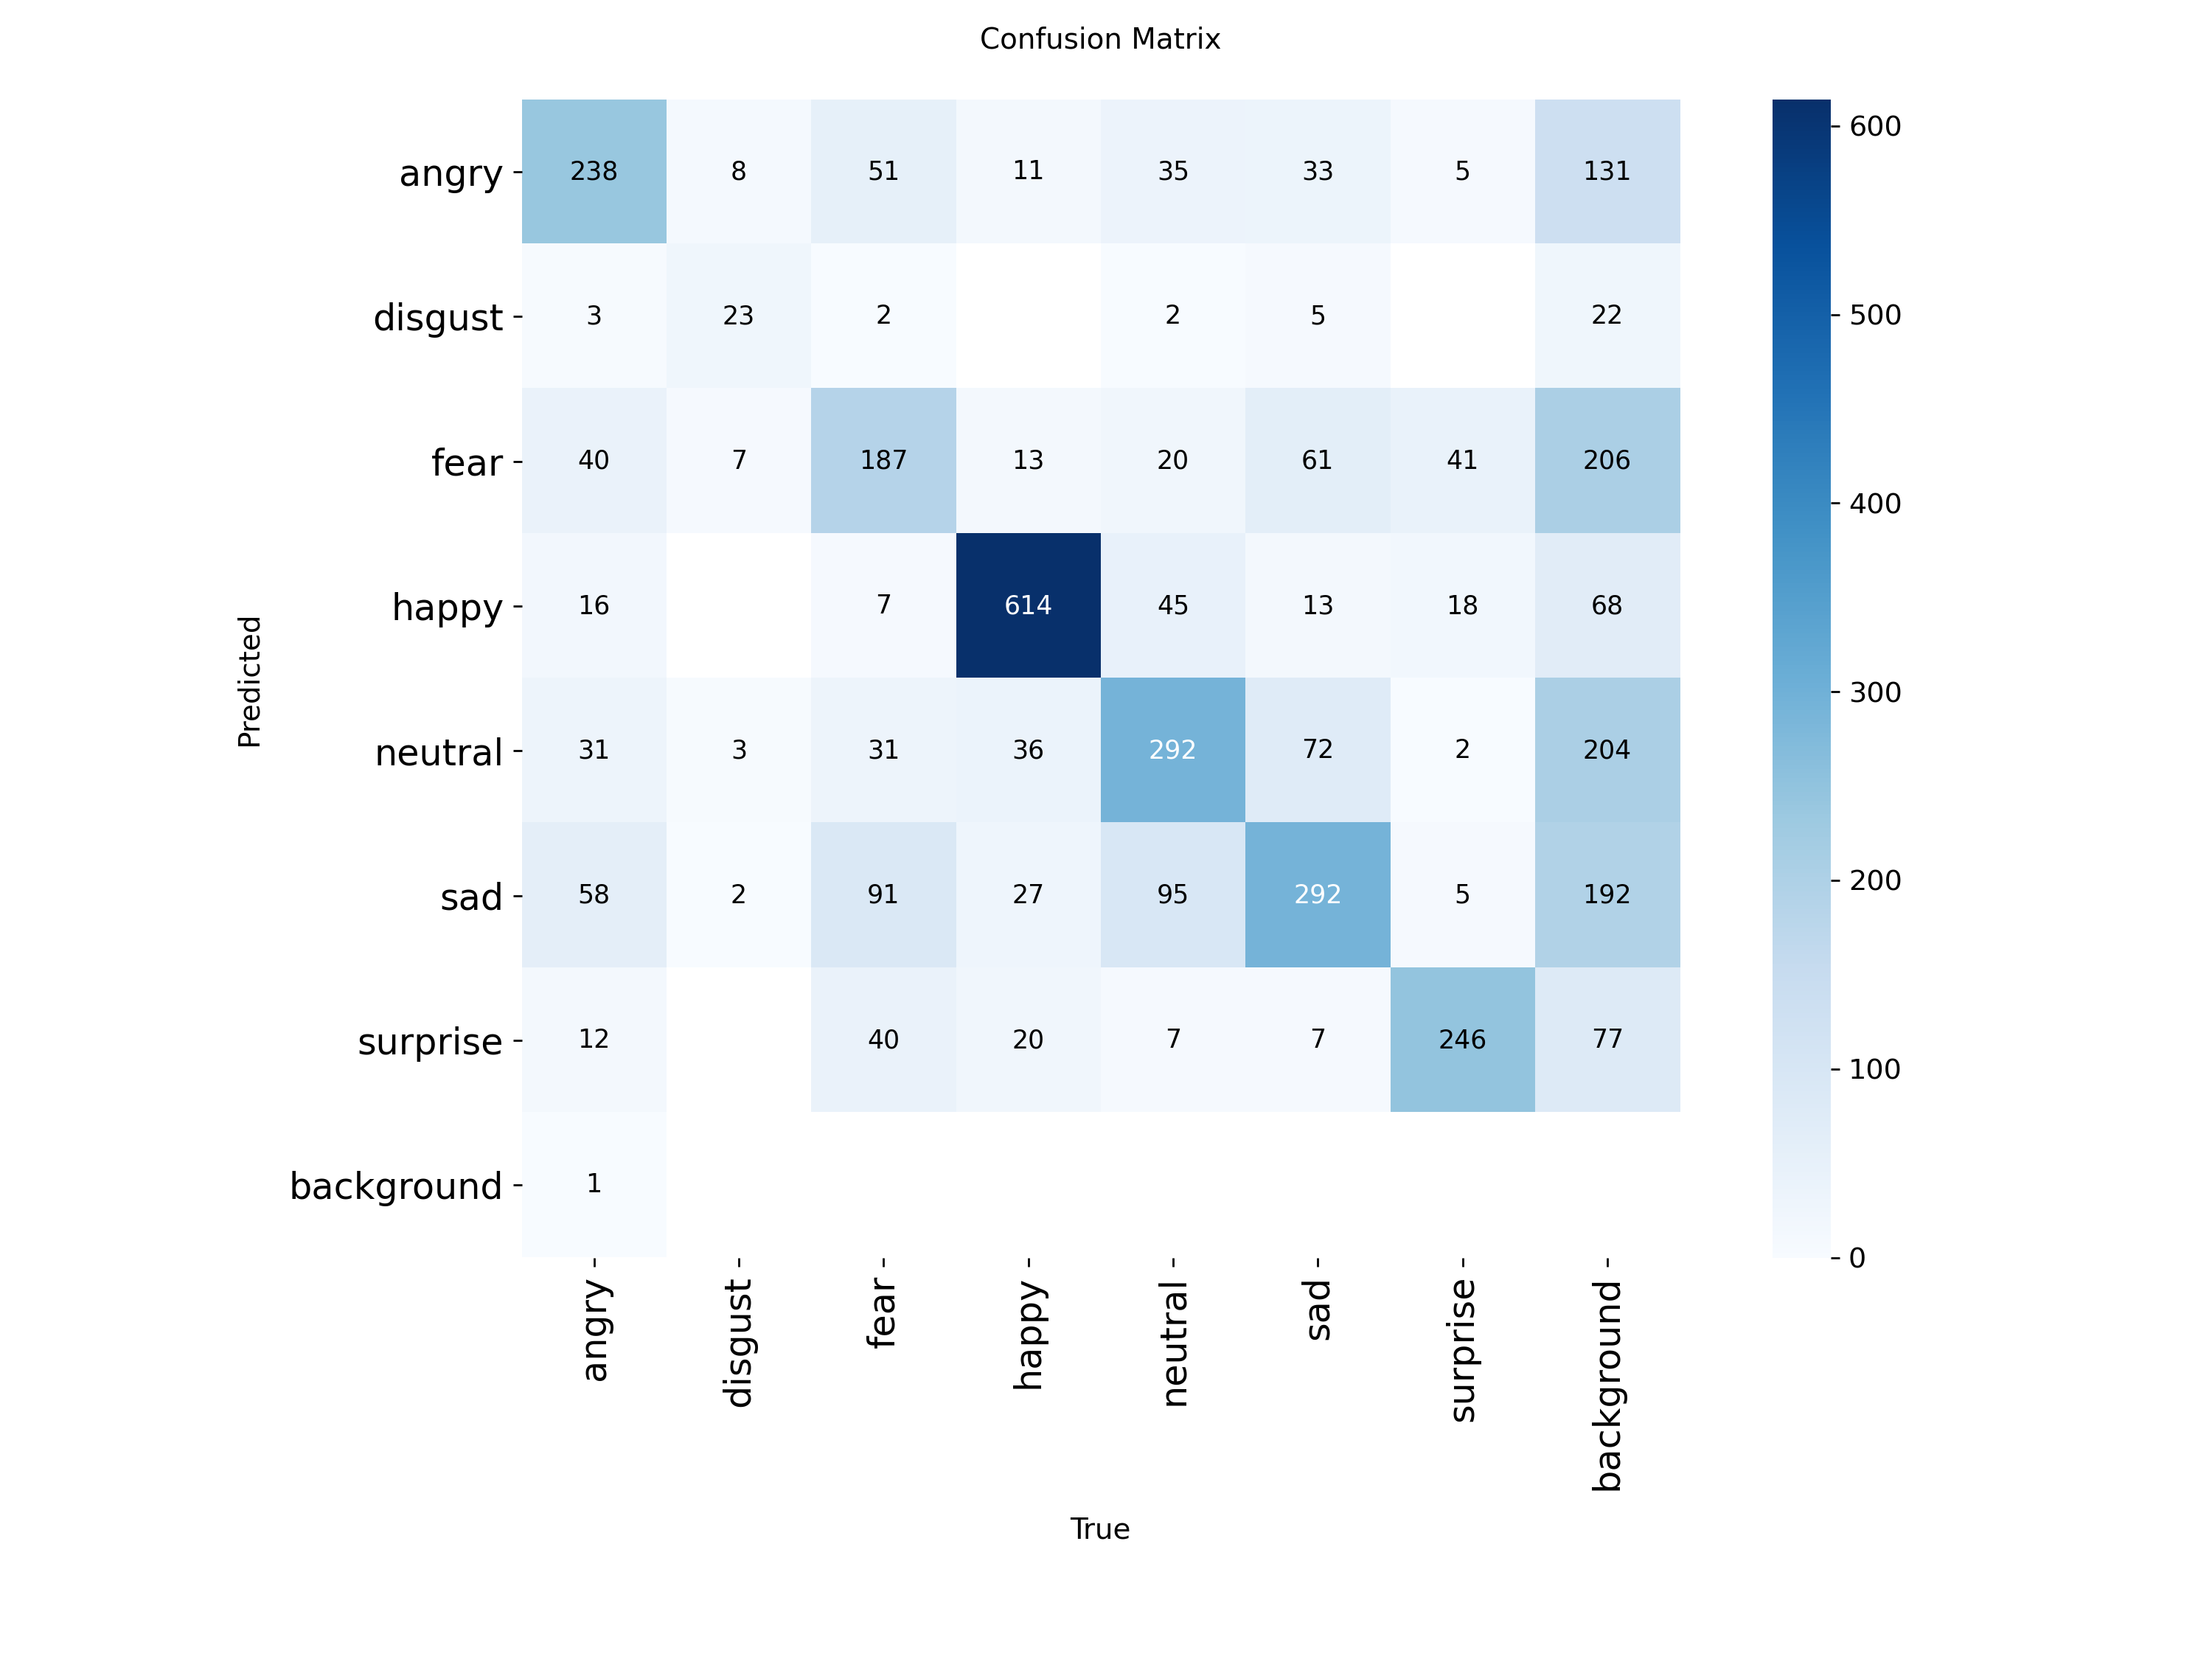

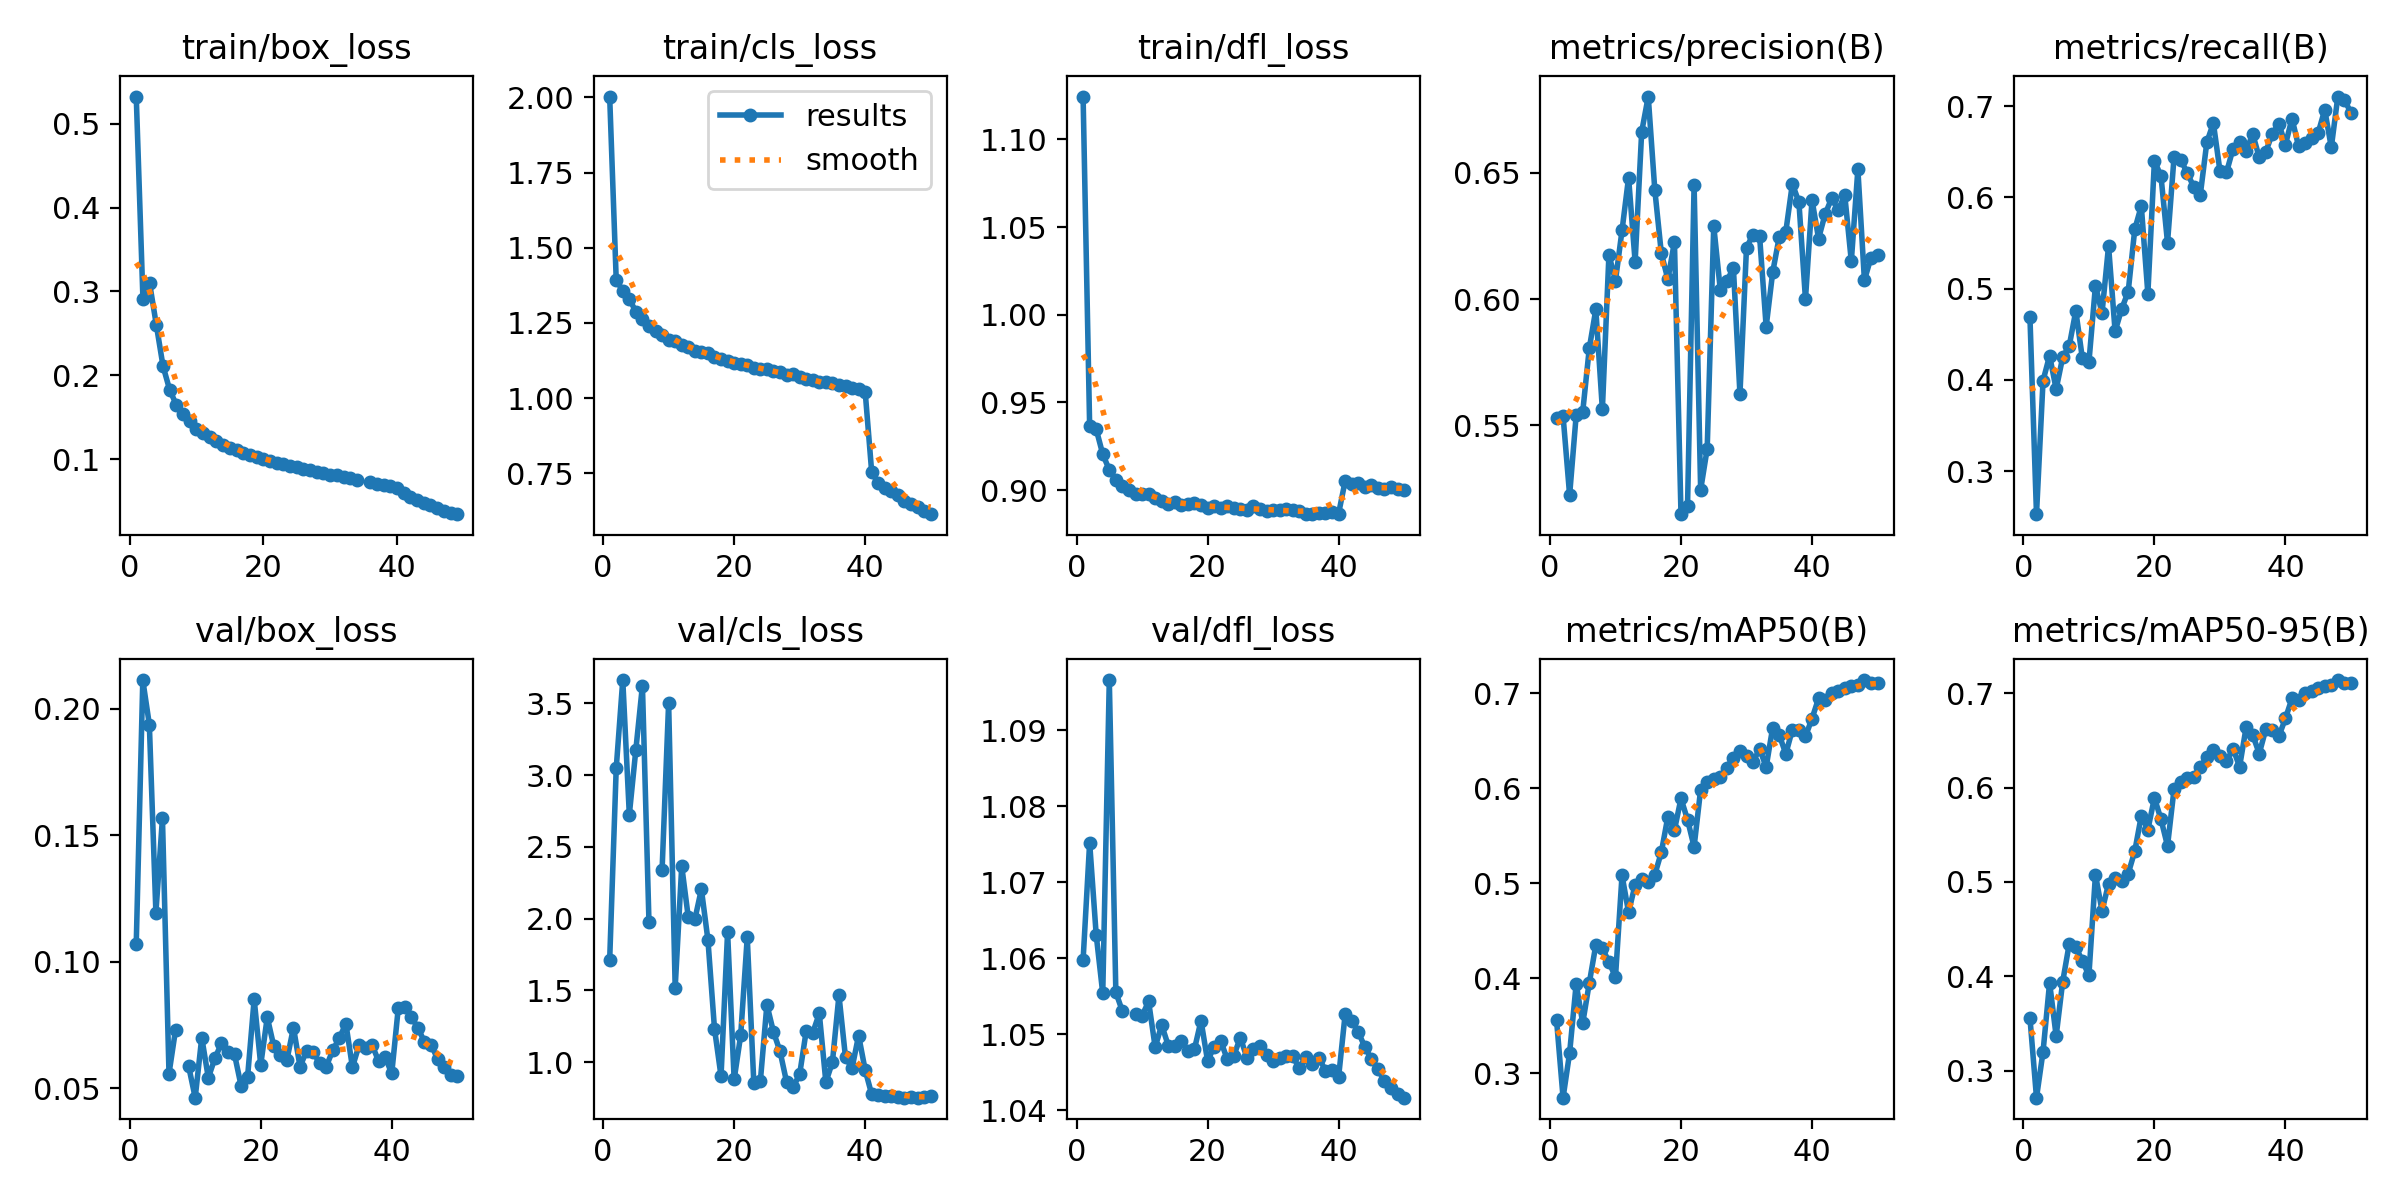

In [ ]:
display(Image("runs/detect/runs_exp/exp1_yolo11s3/confusion_matrix.png", width=600))
display(Image("runs/detect/runs_exp/exp1_yolo11s3/results.png", width=600))

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

model = YOLO("runs/detect/runs_exp/exp1_yolo11s3/weights/best.pt")

DATA_ROOT  = Path(r"C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo")
VAL_IMAGES = DATA_ROOT / "images" / "val"
VAL_LABELS = DATA_ROOT / "labels" / "val"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def read_gt(label_path):
    if not label_path.exists():
        return None
    lines = label_path.read_text().strip().splitlines()
    if not lines:
        return None
    return int(lines[0].split()[0])

y_true, y_pred = [], []

for img_path in VAL_IMAGES.iterdir():
    if img_path.suffix.lower() not in IMG_EXTS:
        continue

    gt = read_gt(VAL_LABELS / f"{img_path.stem}.txt")
    if gt is None:
        continue

    results = model.predict(str(img_path), verbose=False)
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        continue

    confs = boxes.conf.cpu().numpy()
    classes = boxes.cls.cpu().numpy()
    pred = int(classes[np.argmax(confs)])

    y_true.append(gt)
    y_pred.append(pred)

acc = accuracy_score(y_true, y_pred)
print(f"\nexp1_yolo11s3 Accuracy: {acc:.4f}\n")
print(classification_report(y_true, y_pred, target_names=list(model.names.values()), digits=2))


exp1_yolo11s3 Accuracy: 0.6735

              precision    recall  f1-score   support

       angry       0.59      0.64      0.62       398
     disgust       0.80      0.47      0.59        43
        fear       0.56      0.44      0.49       409
       happy       0.84      0.88      0.86       721
     neutral       0.59      0.70      0.64       496
         sad       0.58      0.53      0.55       483
    surprise       0.79      0.75      0.77       317

    accuracy                           0.67      2867
   macro avg       0.68      0.63      0.65      2867
weighted avg       0.67      0.67      0.67      2867



<Figure size 800x500 with 1 Axes>

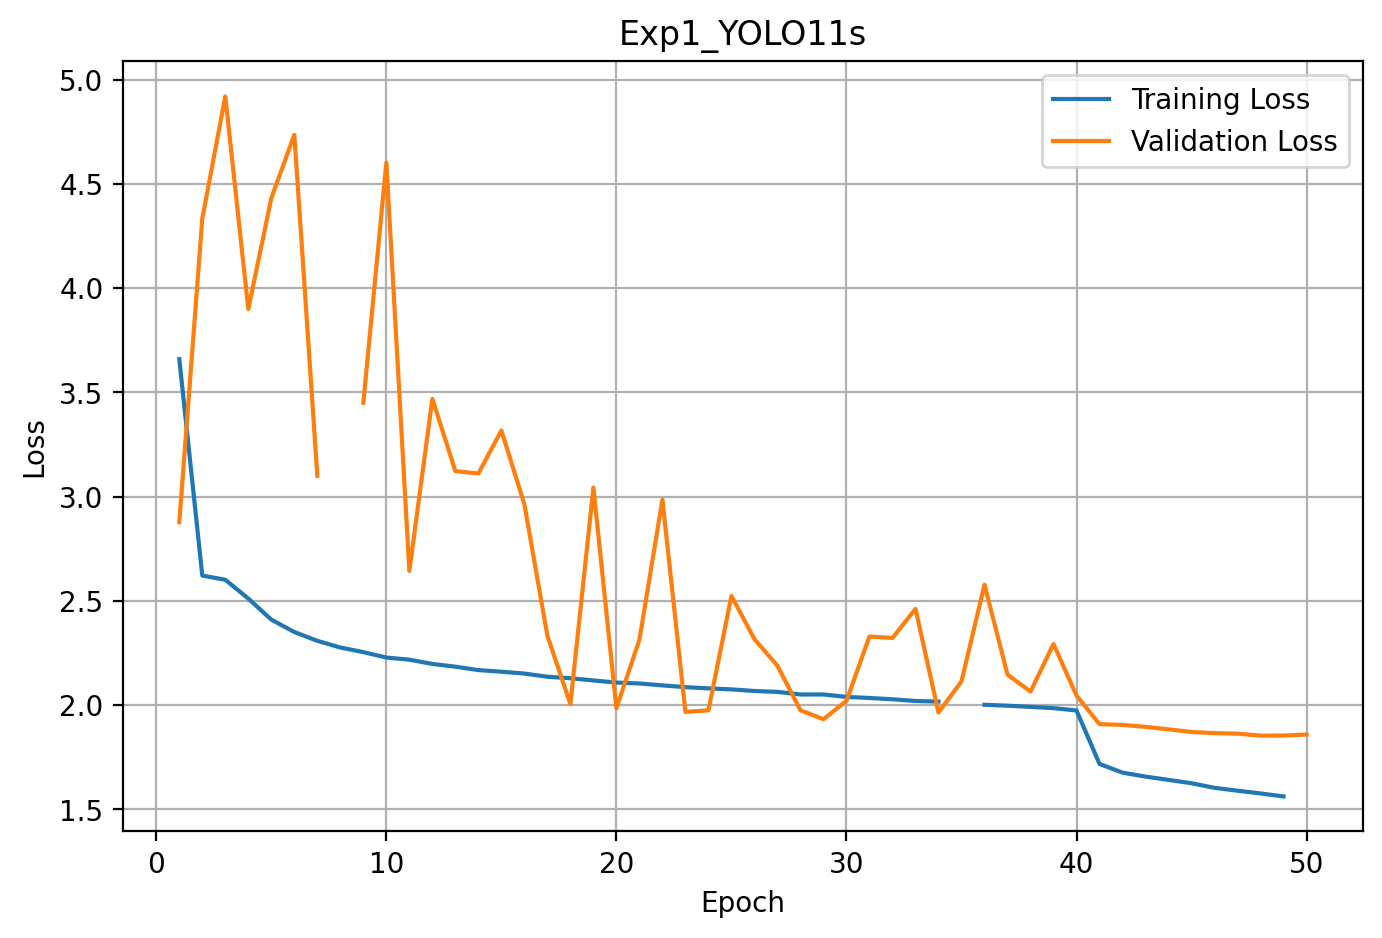

In [ ]:
plot_loss("runs/detect/runs_exp/exp1_yolo11s3", "Exp1_YOLO11s")
display(Image("runs/detect/runs_exp/exp1_yolo11s3/loss_curve.png"))

<Figure size 800x500 with 1 Axes>

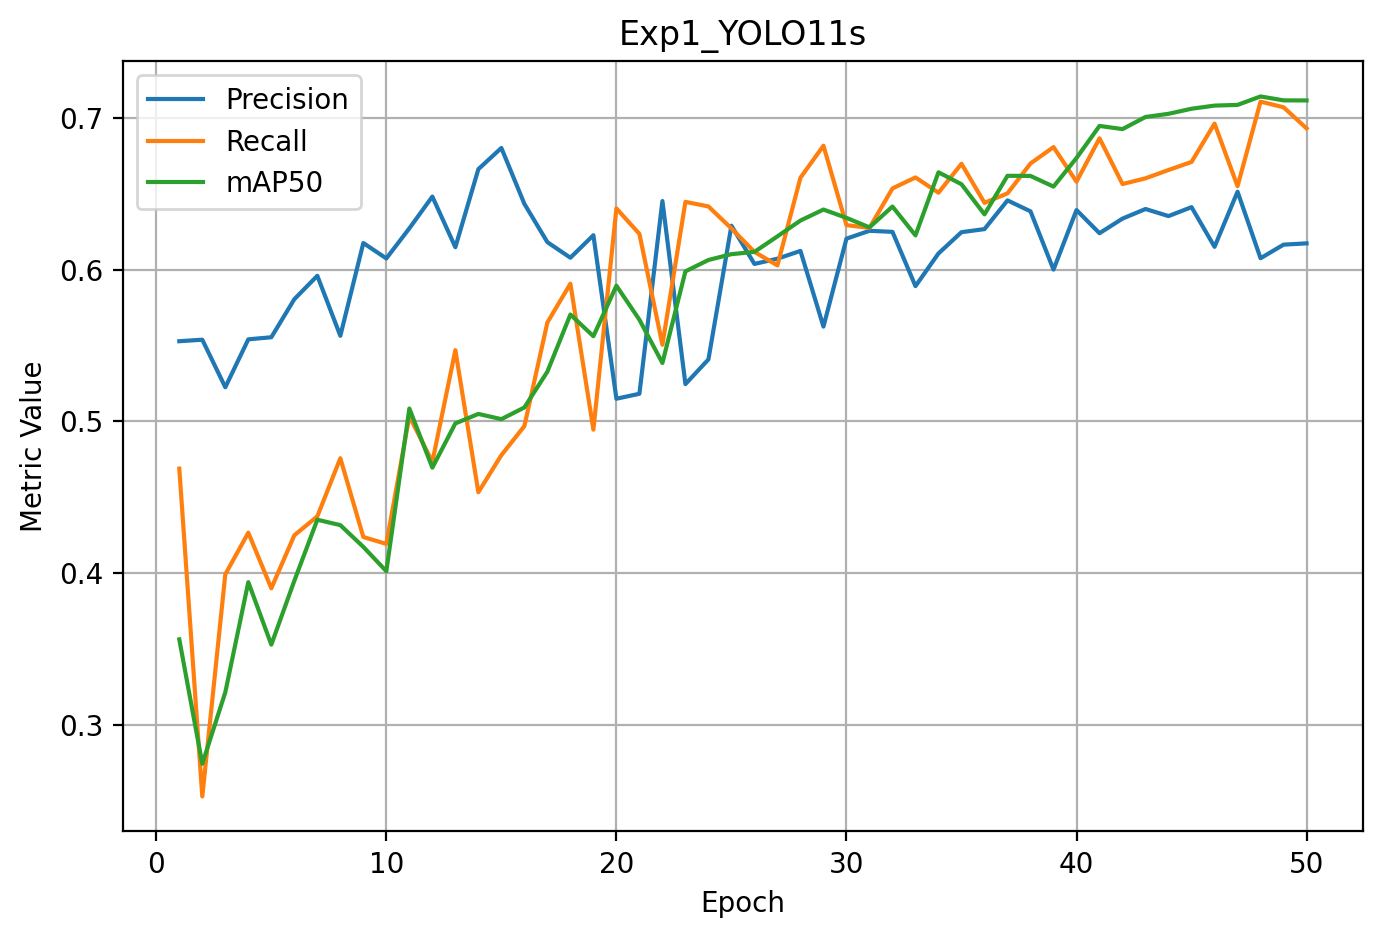

In [ ]:
plot_metrics("runs/detect/runs_exp/exp1_yolo11s3", "Exp1_YOLO11s")
display(Image("runs/detect/runs_exp/exp1_yolo11s3/metrics_curve.png"))

Improvement 2: Higher Resolution (imgsz=160)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

model.train(
    data="dataset_yolo/data.yaml",
    epochs=50,
    imgsz=160,
    batch=64,
    device=0,
    project="runs_exp",
    name="exp2_img160",
    plots=True
)

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=160, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=exp2_img160, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020920CBD690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [ ]:
import glob, os
from ultralytics import YOLO

runs = glob.glob("runs/**/exp2_img160*", recursive=True)

if not runs:
    raise FileNotFoundError("No exp2_img160 run found anywhere under runs/")

RUN_DIR = max(runs, key=os.path.getmtime)
BEST_PT = os.path.join(RUN_DIR, "weights", "best.pt")

print("Found:", RUN_DIR)

model = YOLO(BEST_PT)
metrics = model.val(data="dataset_yolo/data.yaml", plots=True)

print(metrics)

Found: runs\detect\runs_exp\exp2_img160
Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 12.73.6 MB/s, size: 1.1 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 13.1it/s 13.8s0.1s
                   all       2868       2868      0.548      0.644       0.63      0.607
                 angry        399        399      0.559      0.614      0.595      0.578
               disgust         43         43      0.417      0.395      0.476      0.456
                  fear        409        409       0.49      0.406      0.468      0.424
               

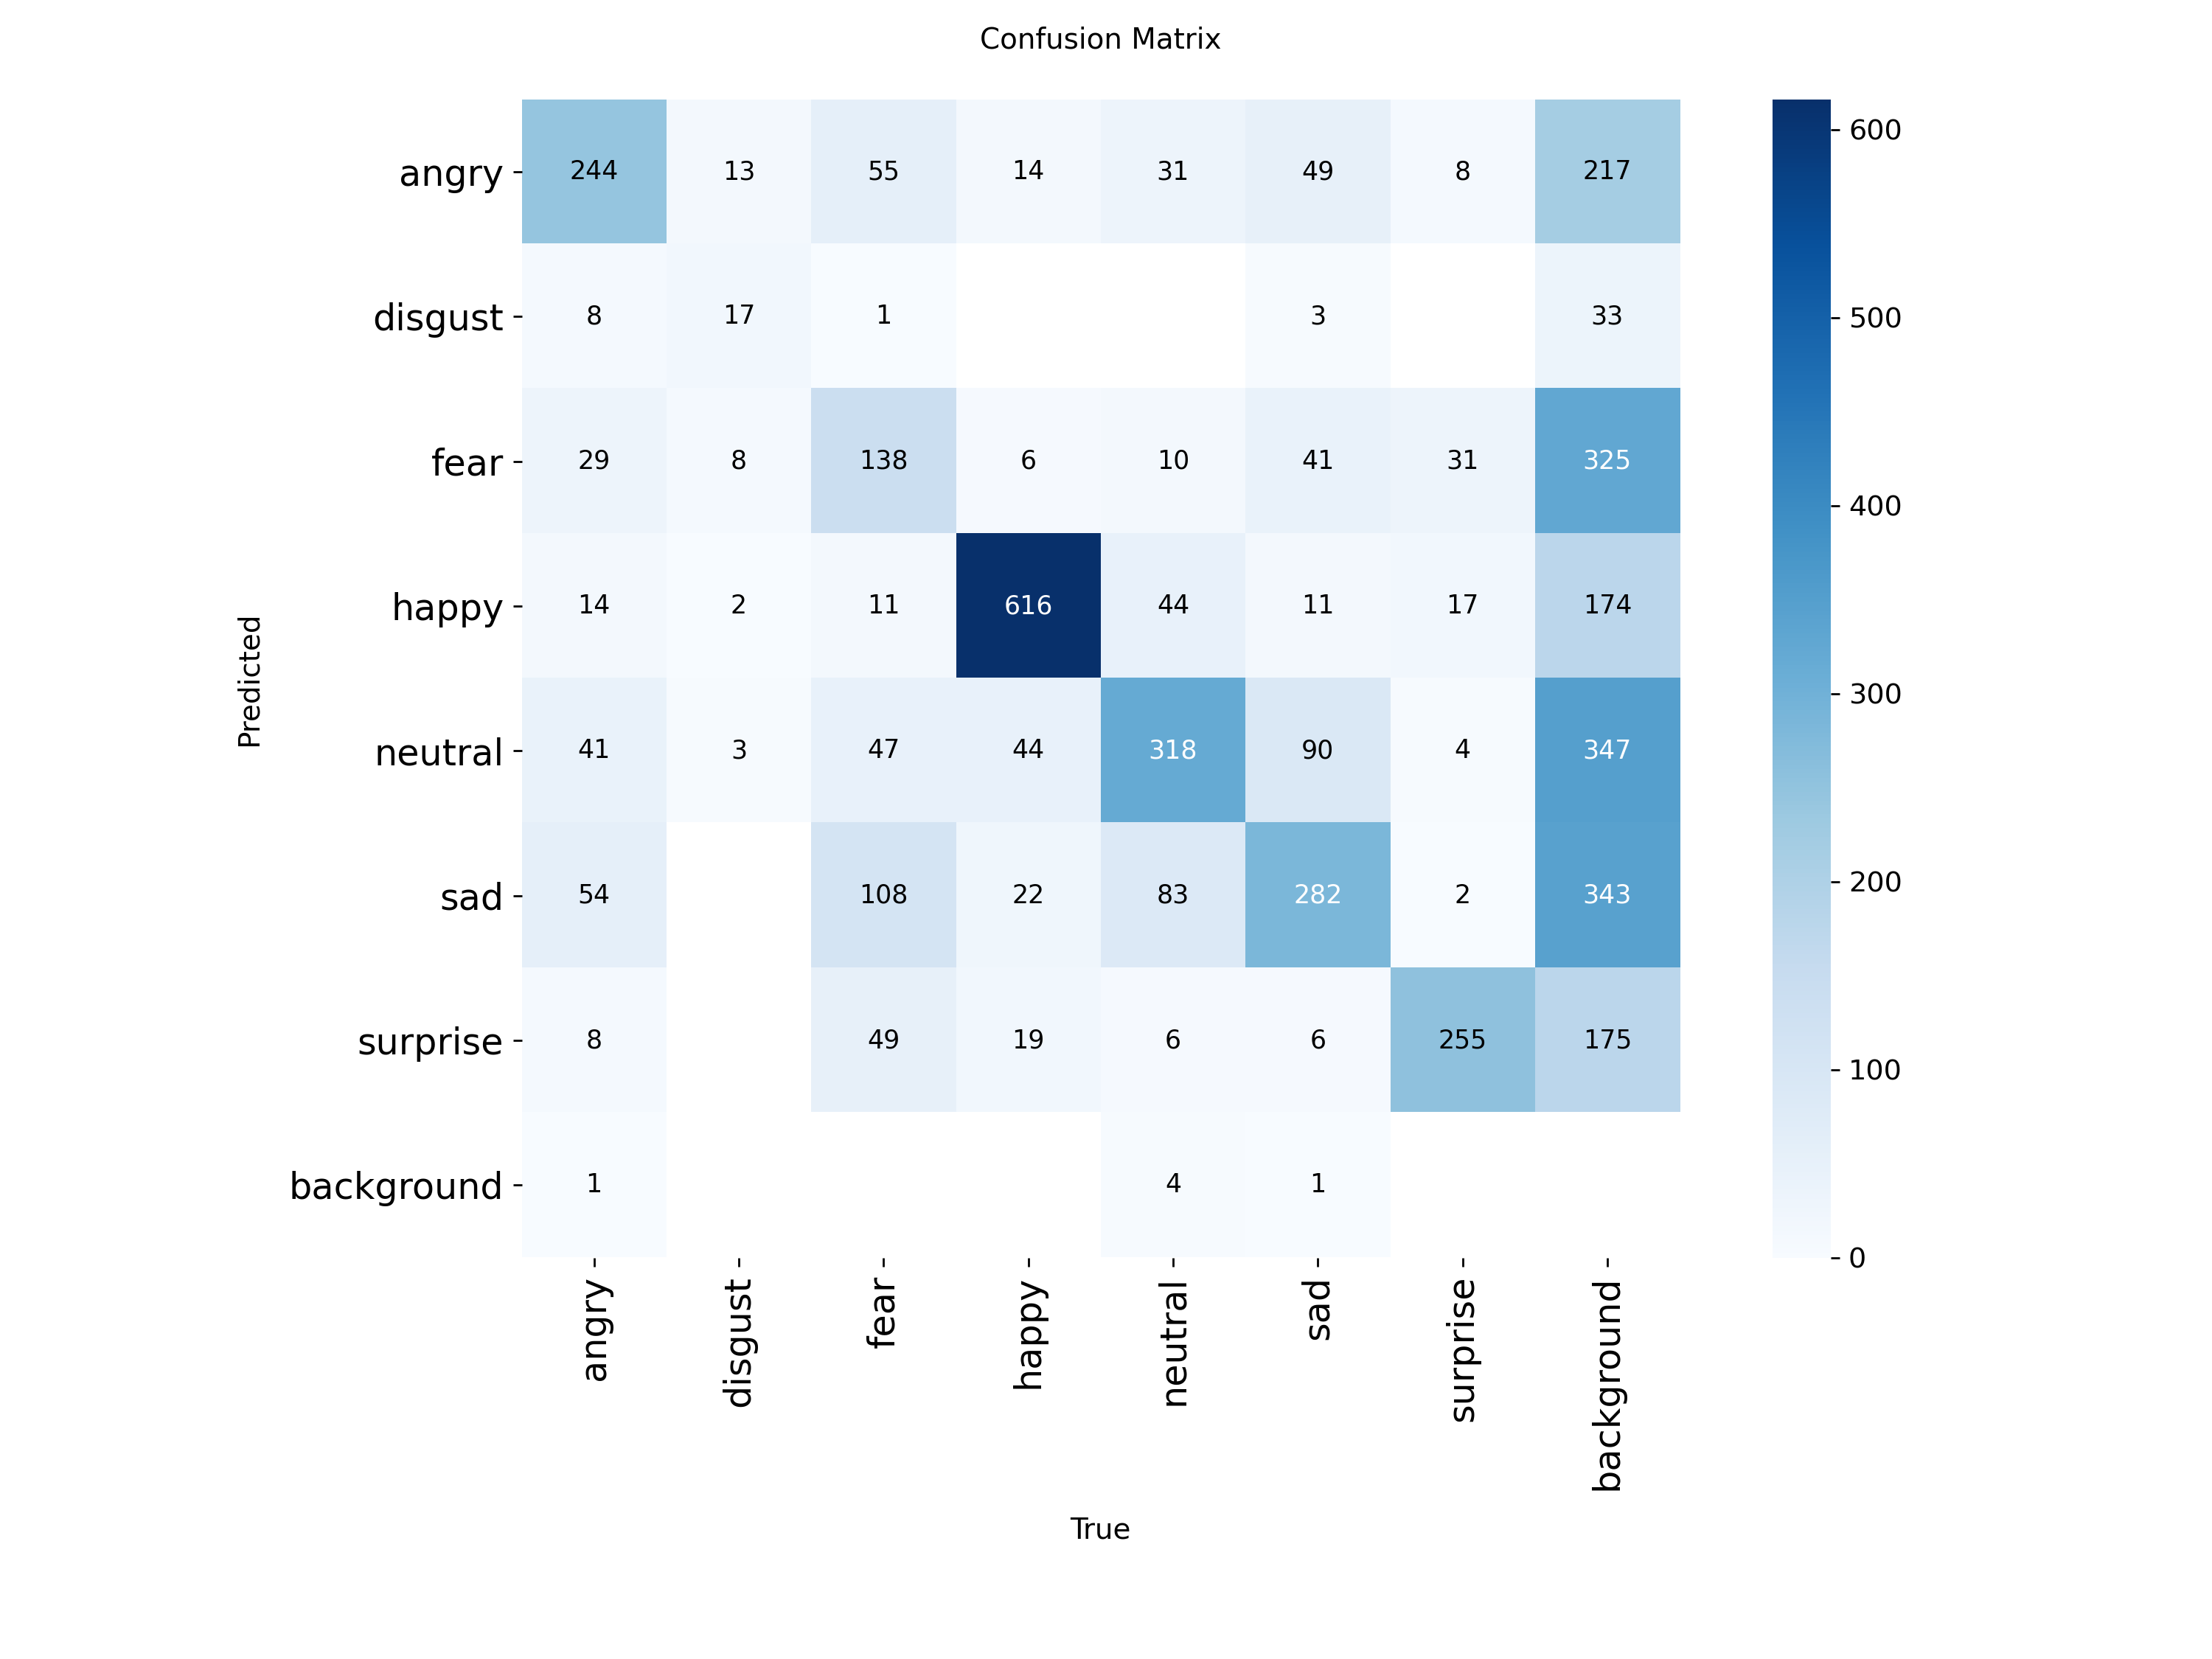

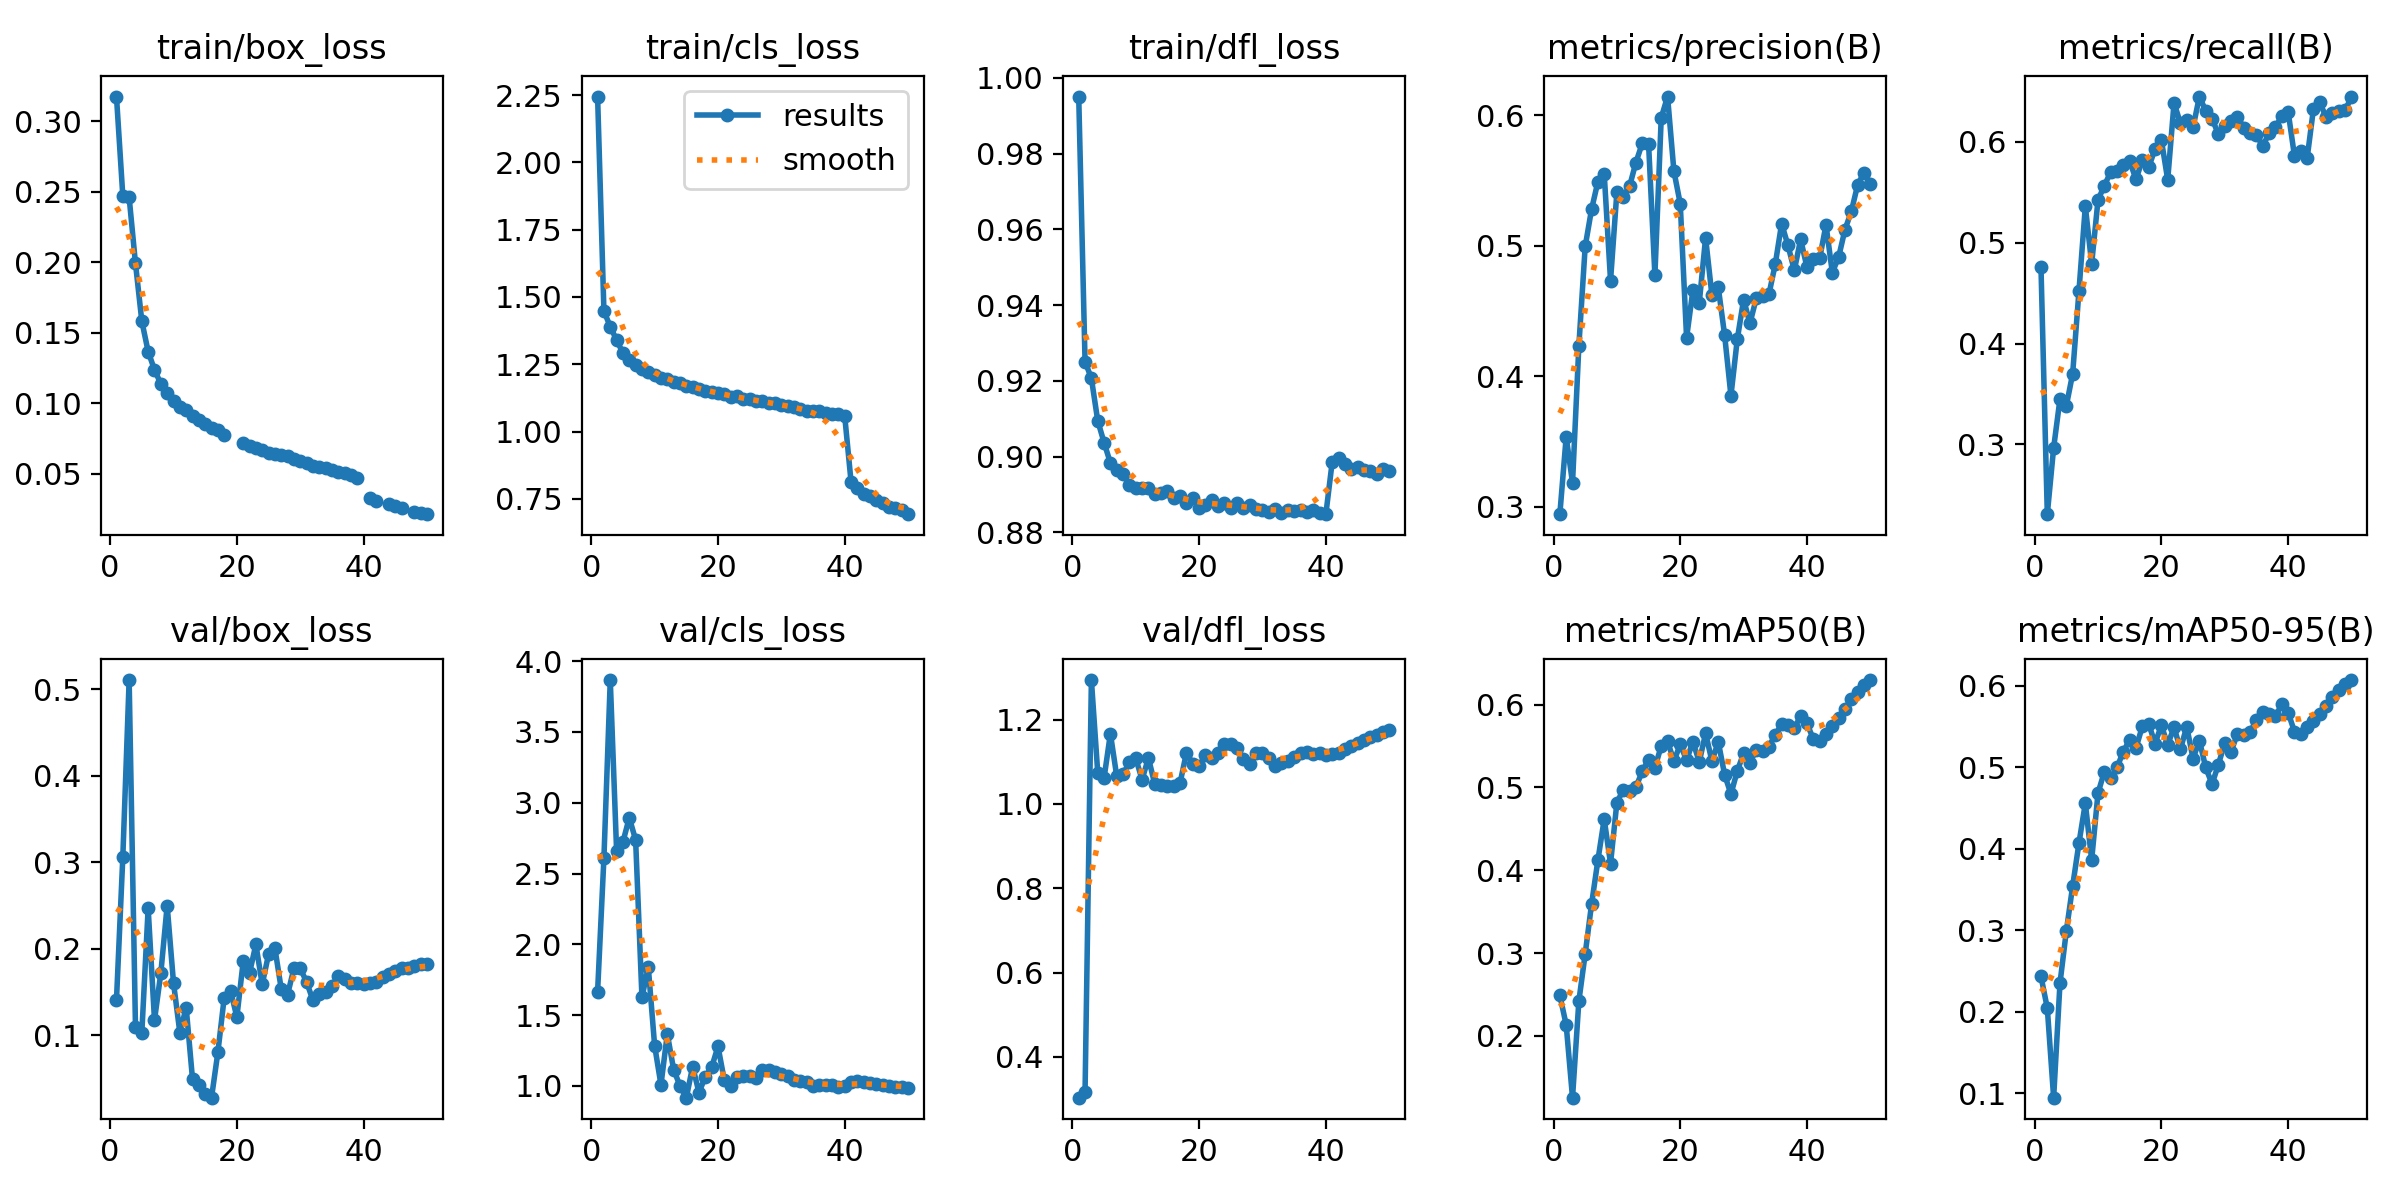

In [ ]:
display(Image("runs/detect/runs_exp/exp2_img160/confusion_matrix.png", width=600))
display(Image("runs/detect/runs_exp/exp2_img160/results.png", width=600))

In [ ]:
from ultralytics import YOLO
import pandas as pd

# Load model
model = YOLO("runs/detect/runs_exp/exp2_img160/weights/best.pt")

# Validate
metrics = model.val(data="dataset_yolo/data.yaml")

names = metrics.names
p = metrics.box.p
r = metrics.box.r
ap50 = metrics.box.ap50
ap = metrics.box.ap

rows = []
for i, name in names.items():
    rows.append({
        "Class": name,
        "Precision": float(p[i]),
        "Recall": float(r[i]),
        "mAP50": float(ap50[i]),
        "mAP50-95": float(ap[i]),
        "F1": float(2 * p[i] * r[i] / (p[i] + r[i] + 1e-16))
    })

df2 = pd.DataFrame(rows).sort_values("Class")
print(df2)

df2.to_csv("per_class_metrics_exp2_img160.csv", index=False)
print("Saved as per_class_metrics_exp2_img160.csv")

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 10.93.2 MB/s, size: 1.1 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 14.2it/s 12.7s0.1s
                   all       2868       2868      0.548      0.644       0.63      0.607
                 angry        399        399      0.559      0.614      0.595      0.578
               disgust         43         43      0.417      0.395      0.476      0.456
                  fear        409        409       0.49      0.406      0.468      0.424
                 happy        721        721      0.751

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

model = YOLO("runs/detect/runs_exp/exp2_img160/weights/best.pt")

DATA_ROOT  = Path(r"C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo")
VAL_IMAGES = DATA_ROOT / "images" / "val"
VAL_LABELS = DATA_ROOT / "labels" / "val"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def read_gt(label_path):
    if not label_path.exists():
        return None
    lines = label_path.read_text().strip().splitlines()
    if not lines:
        return None
    return int(lines[0].split()[0])

y_true, y_pred = [], []

for img_path in VAL_IMAGES.iterdir():
    if img_path.suffix.lower() not in IMG_EXTS:
        continue

    gt = read_gt(VAL_LABELS / f"{img_path.stem}.txt")
    if gt is None:
        continue

    results = model.predict(str(img_path), verbose=False)
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        continue

    confs = boxes.conf.cpu().numpy()
    classes = boxes.cls.cpu().numpy()
    pred = int(classes[np.argmax(confs)])

    y_true.append(gt)
    y_pred.append(pred)

acc = accuracy_score(y_true, y_pred)
print(f"\nexp2_yolo11n_img160 Accuracy: {acc:.4f}\n")
print(classification_report(y_true, y_pred, target_names=list(model.names.values()), digits=2))


exp2_yolo11n_img160 Accuracy: 0.6743

              precision    recall  f1-score   support

       angry       0.59      0.64      0.61       398
     disgust       0.88      0.35      0.50        43
        fear       0.59      0.33      0.43       409
       happy       0.84      0.88      0.86       721
     neutral       0.57      0.74      0.64       495
         sad       0.59      0.54      0.57       482
    surprise       0.76      0.81      0.79       317

    accuracy                           0.67      2865
   macro avg       0.69      0.62      0.63      2865
weighted avg       0.67      0.67      0.66      2865



<Figure size 800x500 with 1 Axes>

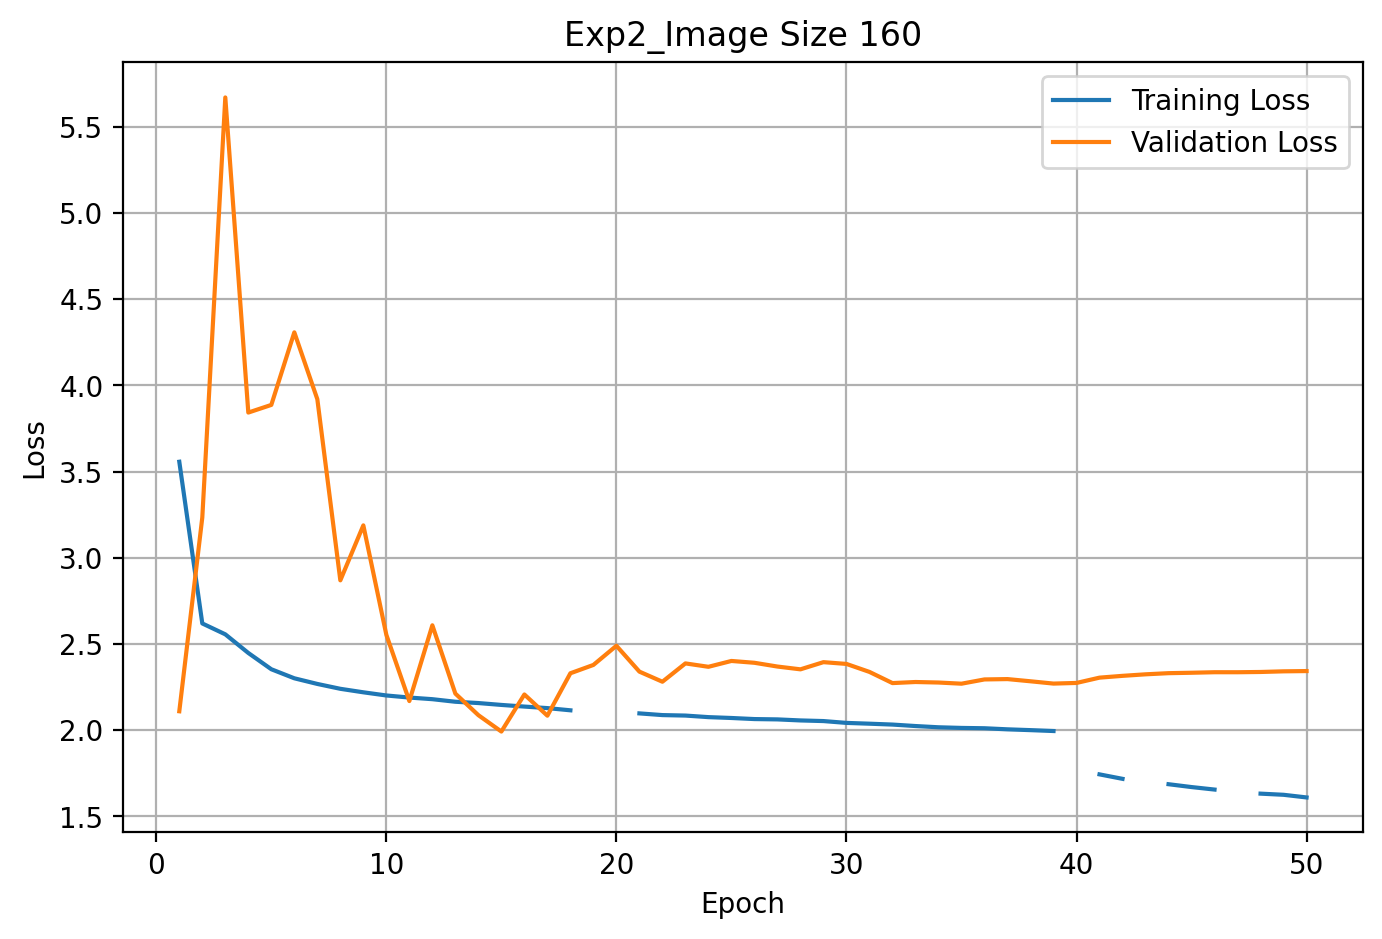

In [ ]:
plot_loss("runs/detect/runs_exp/exp2_img160", "Exp2_Image Size 160")
display(Image("runs/detect/runs_exp/exp2_img160/loss_curve.png"))

<Figure size 800x500 with 1 Axes>

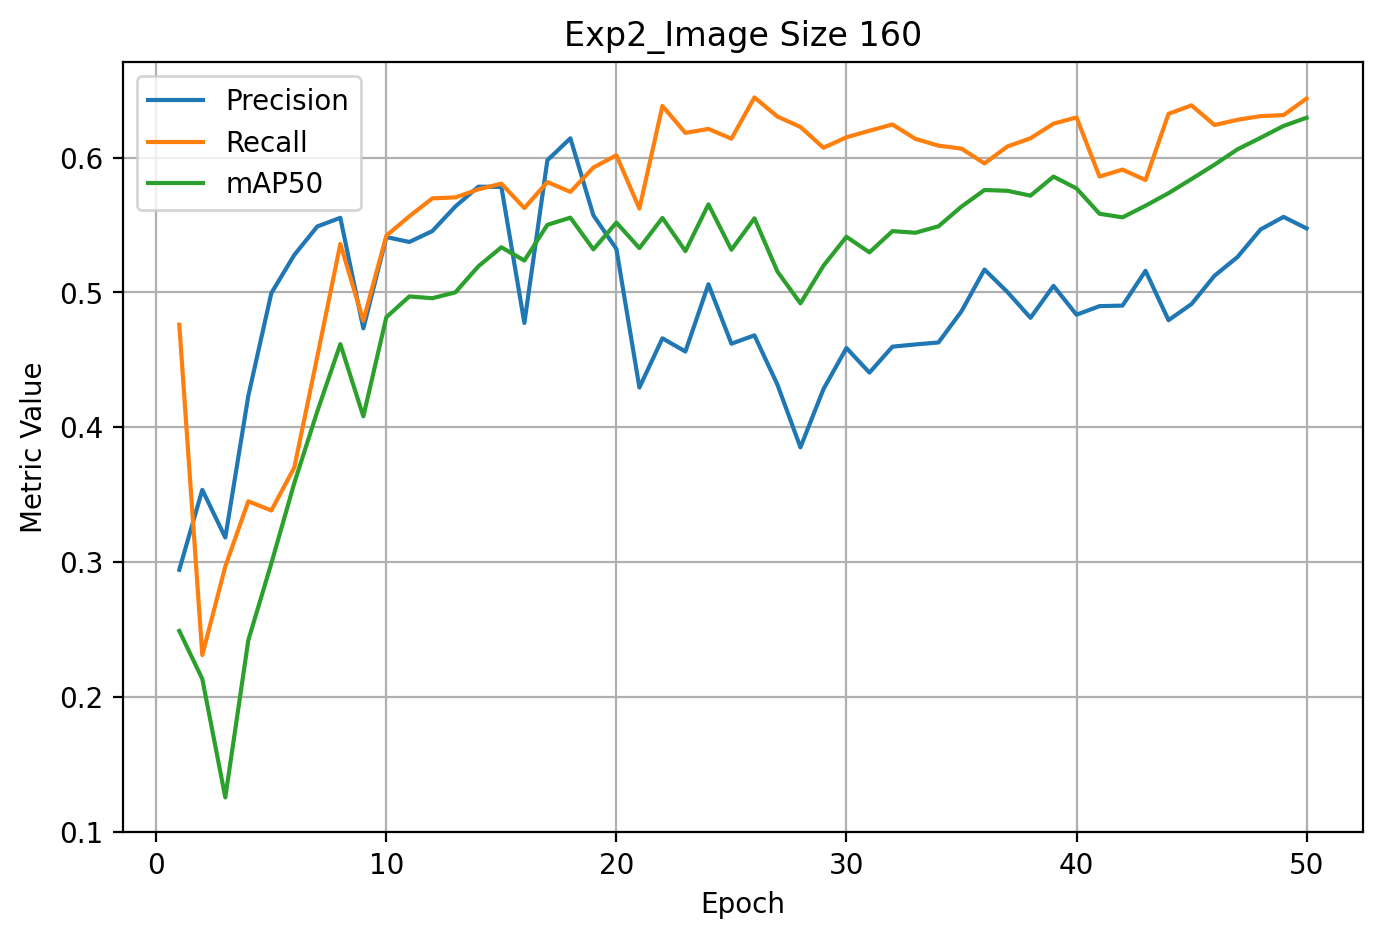

In [ ]:
plot_metrics("runs/detect/runs_exp/exp2_img160", "Exp2_Image Size 160")
display(Image("runs/detect/runs_exp/exp2_img160/metrics_curve.png"))

Improvement 3: Fix Class Imbalance (Oversampling Disgust)
Create new balance folder

In [ ]:
import shutil, random
from pathlib import Path

random.seed(42)

SRC = Path("dataset_yolo")
DST = Path("dataset_yolo_balanced")

# Copy full dataset first (val/test unchanged)
if DST.exists():
    shutil.rmtree(DST)
shutil.copytree(SRC, DST)

train_img_dir = DST / "images" / "train"
train_lbl_dir = DST / "labels" / "train"

def count_classes(label_dir):
    counts = {i: 0 for i in range(7)}
    for lf in label_dir.glob("*.txt"):
        cls = int(lf.read_text().split()[0])  # class id is first number
        counts[cls] += 1
    return counts

counts_before = count_classes(train_lbl_dir)
print("Before:", counts_before)
print("Max class count:", max(counts_before.values()))

Before: {0: 3595, 1: 393, 2: 3688, 3: 6494, 4: 4468, 5: 4347, 6: 2854}
Max class count: 6494


In [ ]:
#classes = ["angry","disgust","fear","happy","neutral","sad","surprise"]


In [ ]:
import shutil, random

DISGUST_ID = 1

counts = count_classes(train_lbl_dir)
max_count = max(counts.values())
TARGET = int(max_count * 0.5)   # 50% of largest class

current = counts[DISGUST_ID]
need = max(0, TARGET - current)

print("Current Disgust:", current)
print("Target Disgust:", TARGET)
print("Need to add:", need)

# collect all disgust label files once
disgust_labels = [lf for lf in train_lbl_dir.glob("*.txt")
                  if int(lf.read_text().split()[0]) == DISGUST_ID]

print("Found disgust label files:", len(disgust_labels))
if not disgust_labels:
    raise RuntimeError("No disgust labels found. Check class ID mapping.")

for i in range(need):
    lf = random.choice(disgust_labels)

    # find corresponding image (.jpg or .png)
    img = train_img_dir / (lf.stem + ".jpg")
    if not img.exists():
        img = train_img_dir / (lf.stem + ".png")
    if not img.exists():
        continue  # skip if image missing

    new_stem = f"{lf.stem}_dup{i}"
    new_lbl = train_lbl_dir / f"{new_stem}.txt"
    new_img = train_img_dir / f"{new_stem}{img.suffix}"

    shutil.copy2(lf, new_lbl)
    shutil.copy2(img, new_img)

counts_after = count_classes(train_lbl_dir)
print("After:", counts_after)

Current Disgust: 393
Target Disgust: 3247
Need to add: 2854
Found disgust label files: 393
After: {0: 3595, 1: 3247, 2: 3688, 3: 6494, 4: 4468, 5: 4347, 6: 2854}


In [ ]:
yaml_path = DST / "data.yaml"
yaml_text = f"""path: {DST.resolve()}
train: images/train
val: images/val
test: images/test

nc: 7
names: ['angry','disgust','fear','happy','neutral','sad','surprise']
"""
yaml_path.write_text(yaml_text)
print("✅ Updated:", yaml_path)
print(yaml_text)

✅ Updated: dataset_yolo_balanced\data.yaml
path: C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo_balanced
train: images/train
val: images/val
test: images/test

nc: 7
names: ['angry','disgust','fear','happy','neutral','sad','surprise']



Train using balance set

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")  # keep same as baseline for fair comparison

model.train(
    data="dataset_yolo_balanced/data.yaml",
    epochs=50,
    imgsz=96,
    batch=128,
    device=0,
    project="runs_exp",
    name="exp3_balanced",
    plots=True
)

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo_balanced/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=96, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=exp3_balanced, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002080A2231D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [ ]:
from ultralytics import YOLO
import os

# ---- Path to balanced experiment ----
BEST_PT = r"runs/detect/runs_exp/exp3_balanced/weights/best.pt"
BALANCED_DATA = r"dataset_yolo_balanced/data.yaml"

# ---- Load model ----
model = YOLO(BEST_PT)

# ---- Validate on balanced dataset ----
metrics = model.val(
    data=BALANCED_DATA,
    split="val",
    plots=True
)

print("✅ Balanced validation completed.")

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 10.03.4 MB/s, size: 1.1 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo_balanced\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 14.7it/s 12.2s0.1s
                   all       2868       2868      0.606      0.675        0.7        0.7
                 angry        399        399      0.627      0.591      0.633      0.633
               disgust         43         43      0.438      0.744      0.746      0.746
                  fear        409        409      0.499      0.484      0.502      0.502
                 happy        721        721  

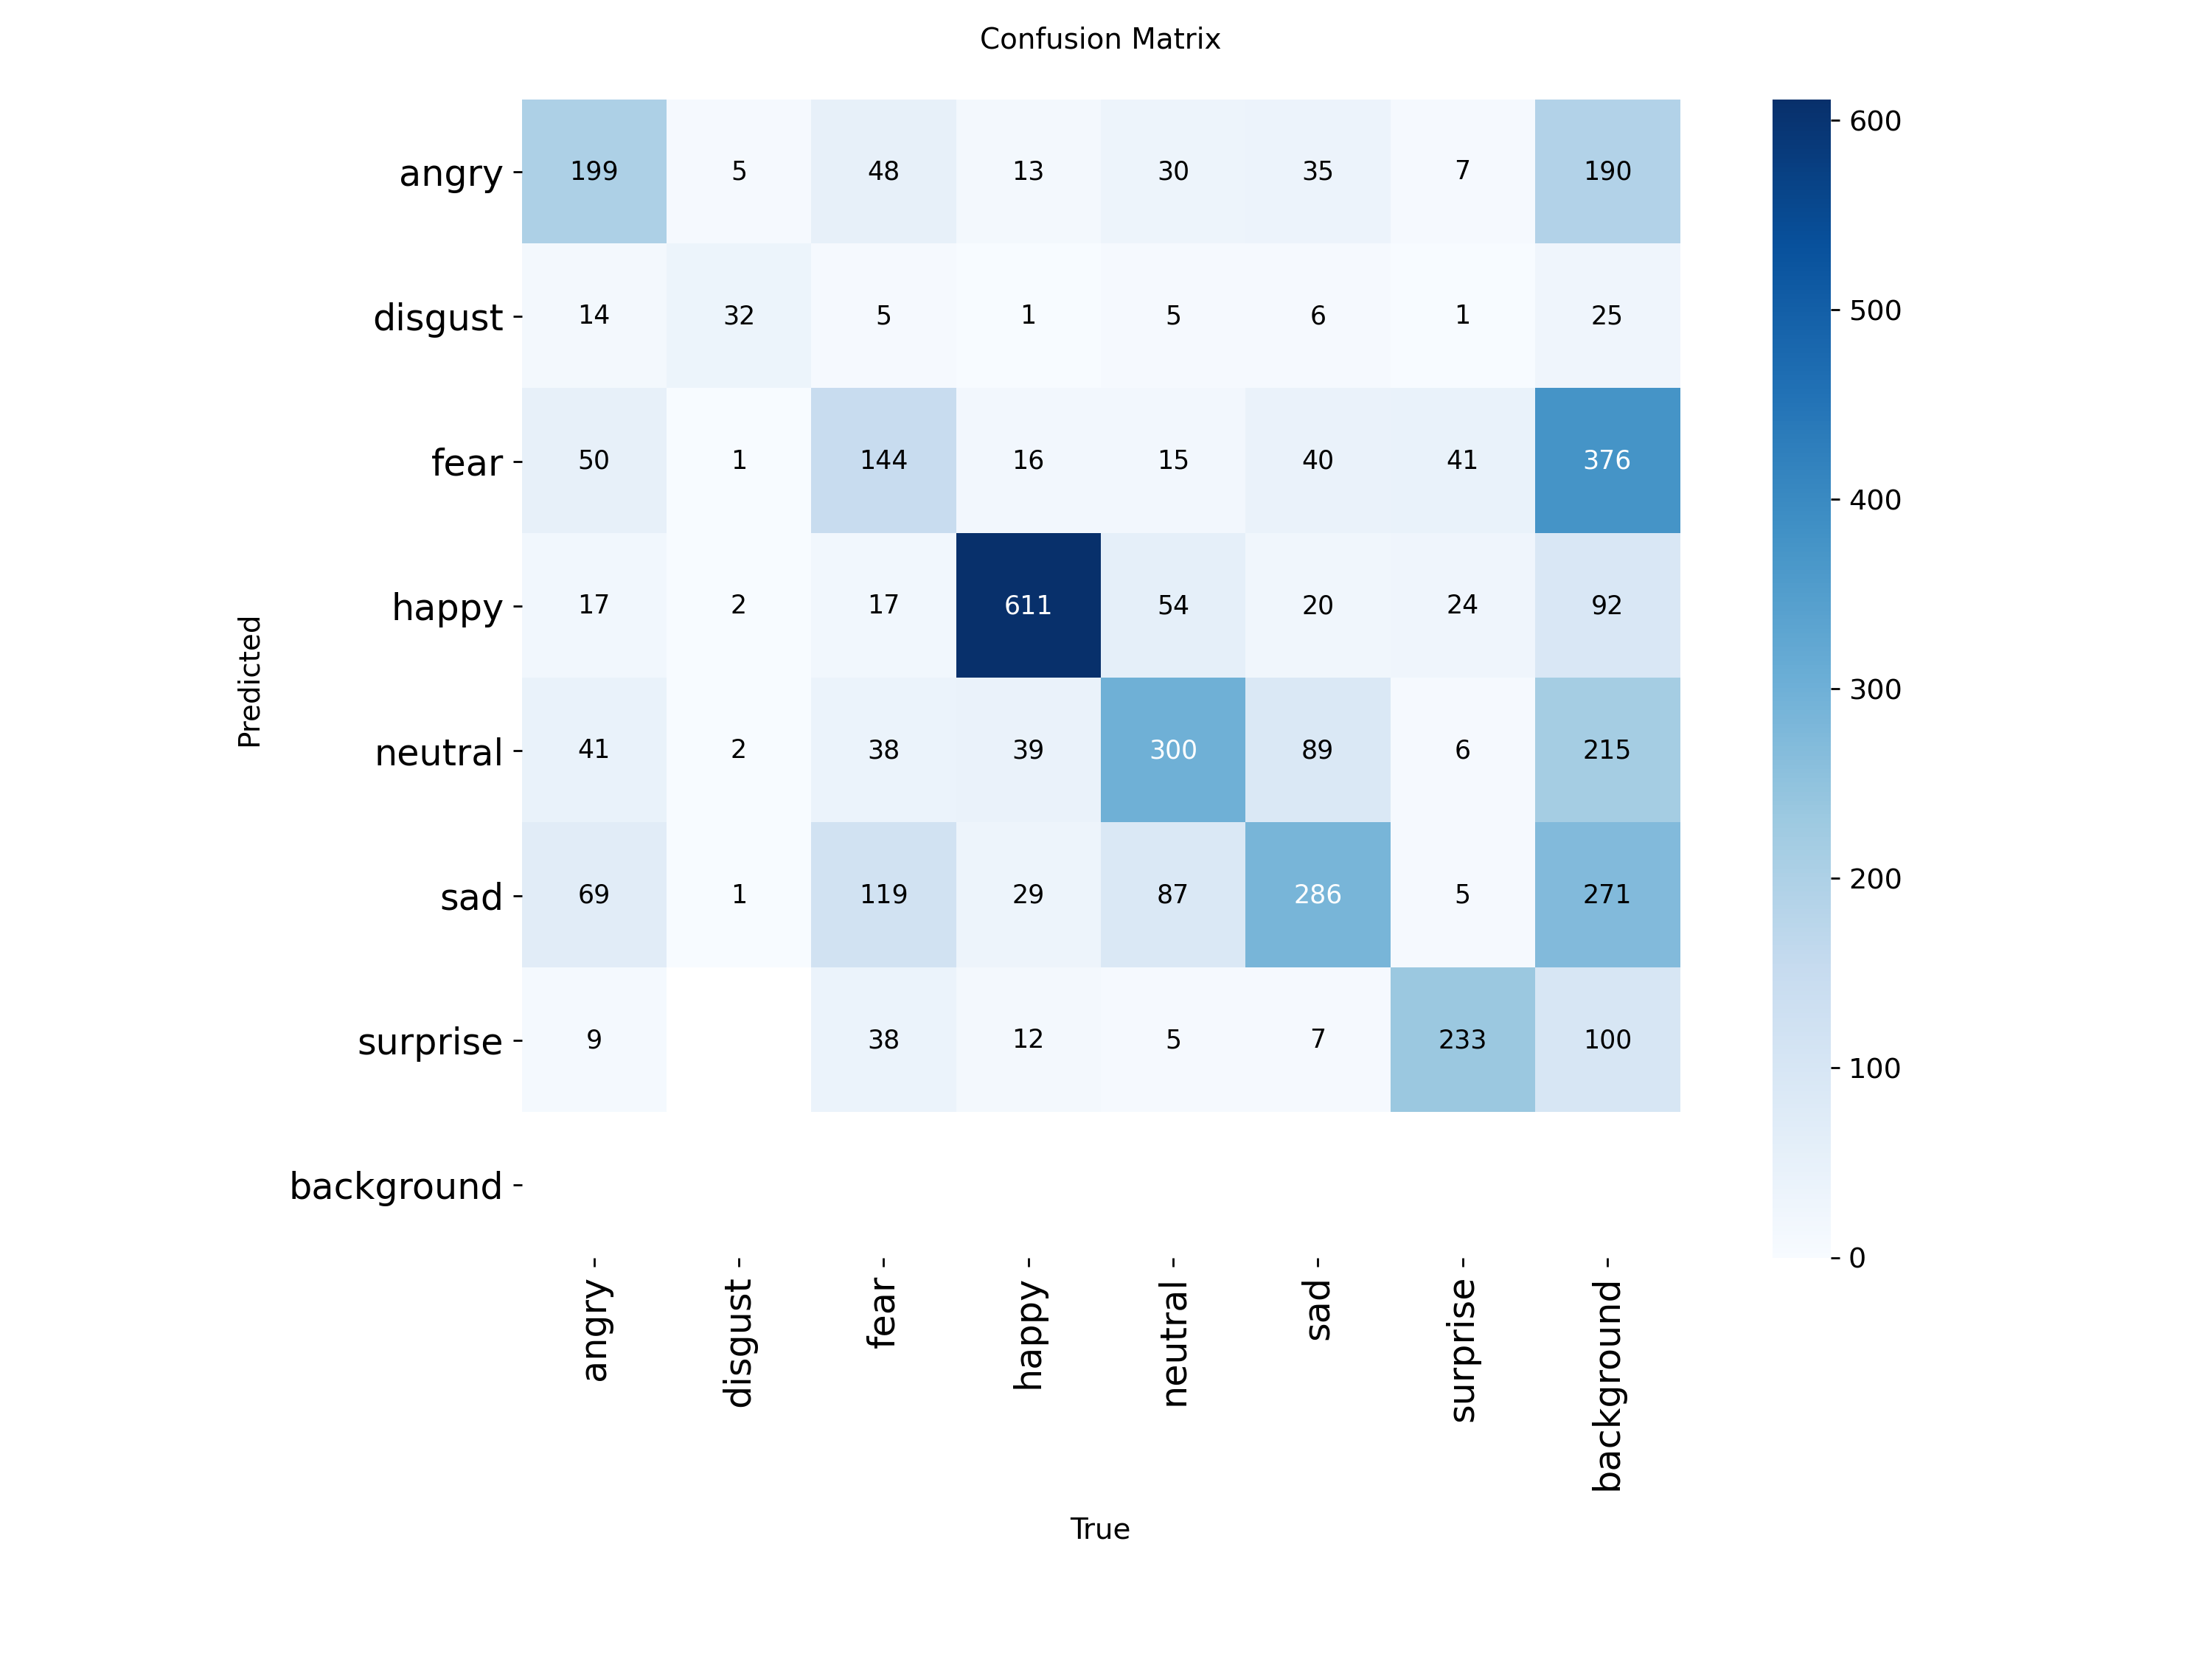

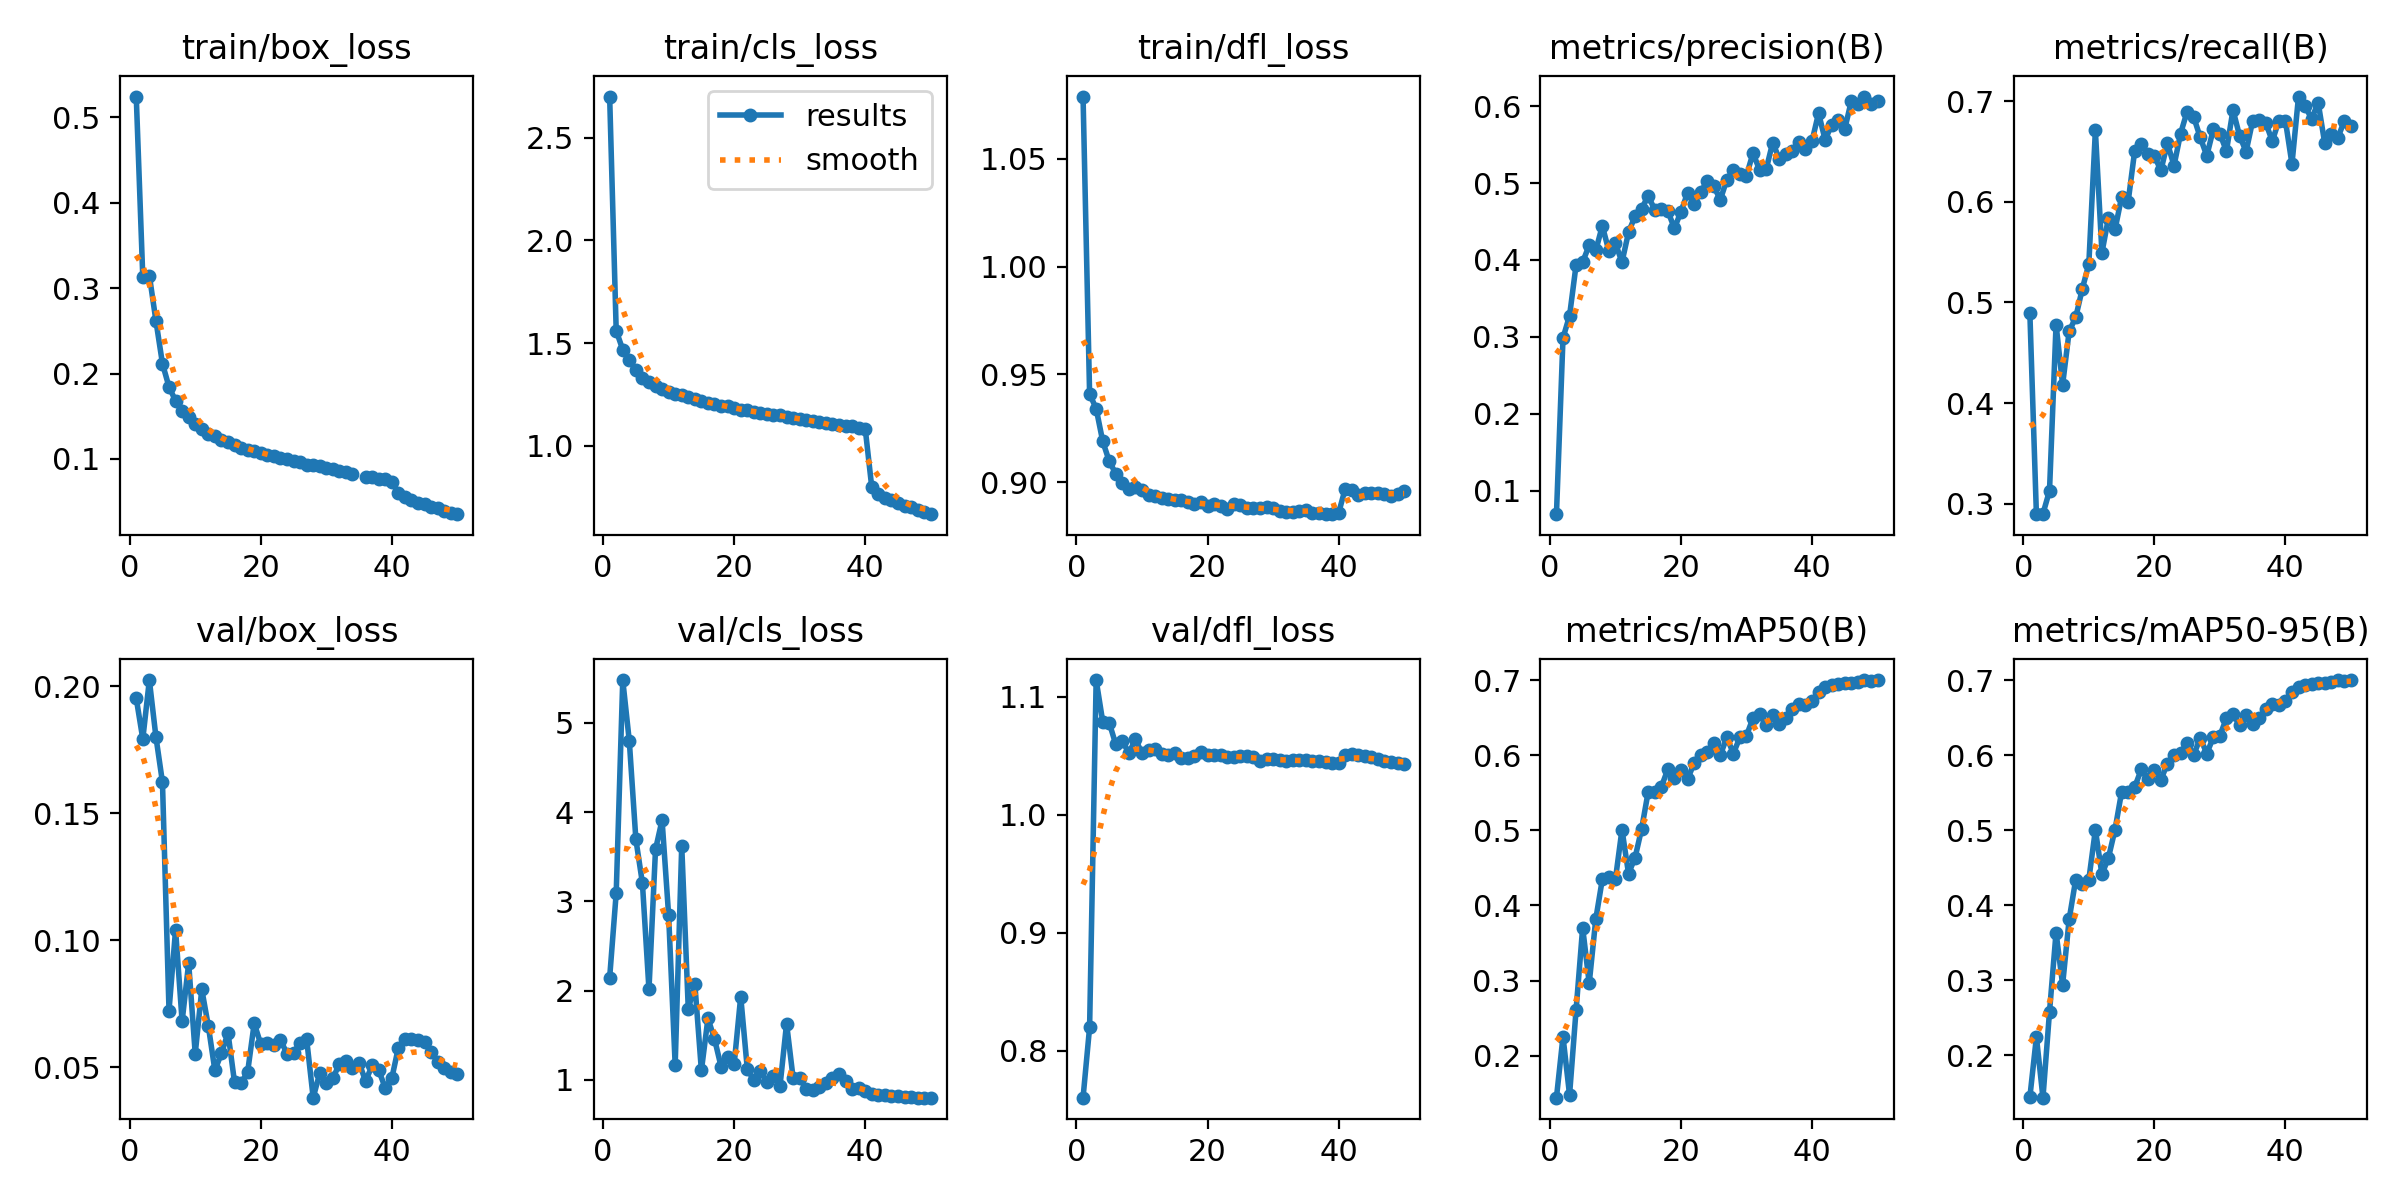

In [ ]:
display(Image("runs/detect/runs_exp/exp3_balanced/confusion_matrix.png", width=600))
display(Image("runs/detect/runs_exp/exp3_balanced/results.png", width=600))

In [ ]:
from ultralytics import YOLO
import pandas as pd

# Load model
model = YOLO("runs/detect/runs_exp/exp3_balanced/weights/best.pt")

# Validate
metrics = model.val(data="dataset_yolo/data.yaml")

names = metrics.names
p = metrics.box.p
r = metrics.box.r
ap50 = metrics.box.ap50
ap = metrics.box.ap

rows = []
for i, name in names.items():
    rows.append({
        "Class": name,
        "Precision": float(p[i]),
        "Recall": float(r[i]),
        "mAP50": float(ap50[i]),
        "mAP50-95": float(ap[i]),
        "F1": float(2 * p[i] * r[i] / (p[i] + r[i] + 1e-16))
    })

df3 = pd.DataFrame(rows).sort_values("Class")
print(df3)

df3.to_csv("per_class_metrics_exp3_balanced.csv", index=False)
print("Saved as per_class_metrics_exp3_balanced.csv")

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 10.72.0 MB/s, size: 1.2 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 14.6it/s 12.3s0.1s
                   all       2868       2868      0.606      0.675        0.7        0.7
                 angry        399        399      0.627      0.591      0.633      0.633
               disgust         43         43      0.438      0.744      0.746      0.746
                  fear        409        409      0.499      0.484      0.502      0.502
                 happy        721        721      0.826

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

model = YOLO("runs/detect/runs_exp/exp3_balanced/weights/best.pt")

DATA_ROOT  = Path(r"C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo")
VAL_IMAGES = DATA_ROOT / "images" / "val"
VAL_LABELS = DATA_ROOT / "labels" / "val"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def read_gt(label_path):
    if not label_path.exists():
        return None
    lines = label_path.read_text().strip().splitlines()
    if not lines:
        return None
    return int(lines[0].split()[0])

y_true, y_pred = [], []

for img_path in VAL_IMAGES.iterdir():
    if img_path.suffix.lower() not in IMG_EXTS:
        continue

    gt = read_gt(VAL_LABELS / f"{img_path.stem}.txt")
    if gt is None:
        continue

    results = model.predict(str(img_path), verbose=False)
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        continue

    confs = boxes.conf.cpu().numpy()
    classes = boxes.cls.cpu().numpy()
    pred = int(classes[np.argmax(confs)])

    y_true.append(gt)
    y_pred.append(pred)

acc = accuracy_score(y_true, y_pred)
print(f"\nexp3_yolo11n With balanced data set Accuracy: {acc:.4f}\n")
print(classification_report(y_true, y_pred, target_names=list(model.names.values()), digits=2))


exp3_yolo11n With balanced data set Accuracy: 0.6548

              precision    recall  f1-score   support

       angry       0.60      0.63      0.61       397
     disgust       0.65      0.74      0.70        43
        fear       0.56      0.36      0.44       409
       happy       0.82      0.87      0.84       720
     neutral       0.54      0.68      0.60       496
         sad       0.57      0.52      0.54       483
    surprise       0.76      0.74      0.75       317

    accuracy                           0.65      2865
   macro avg       0.64      0.65      0.64      2865
weighted avg       0.65      0.65      0.65      2865



<Figure size 800x500 with 1 Axes>

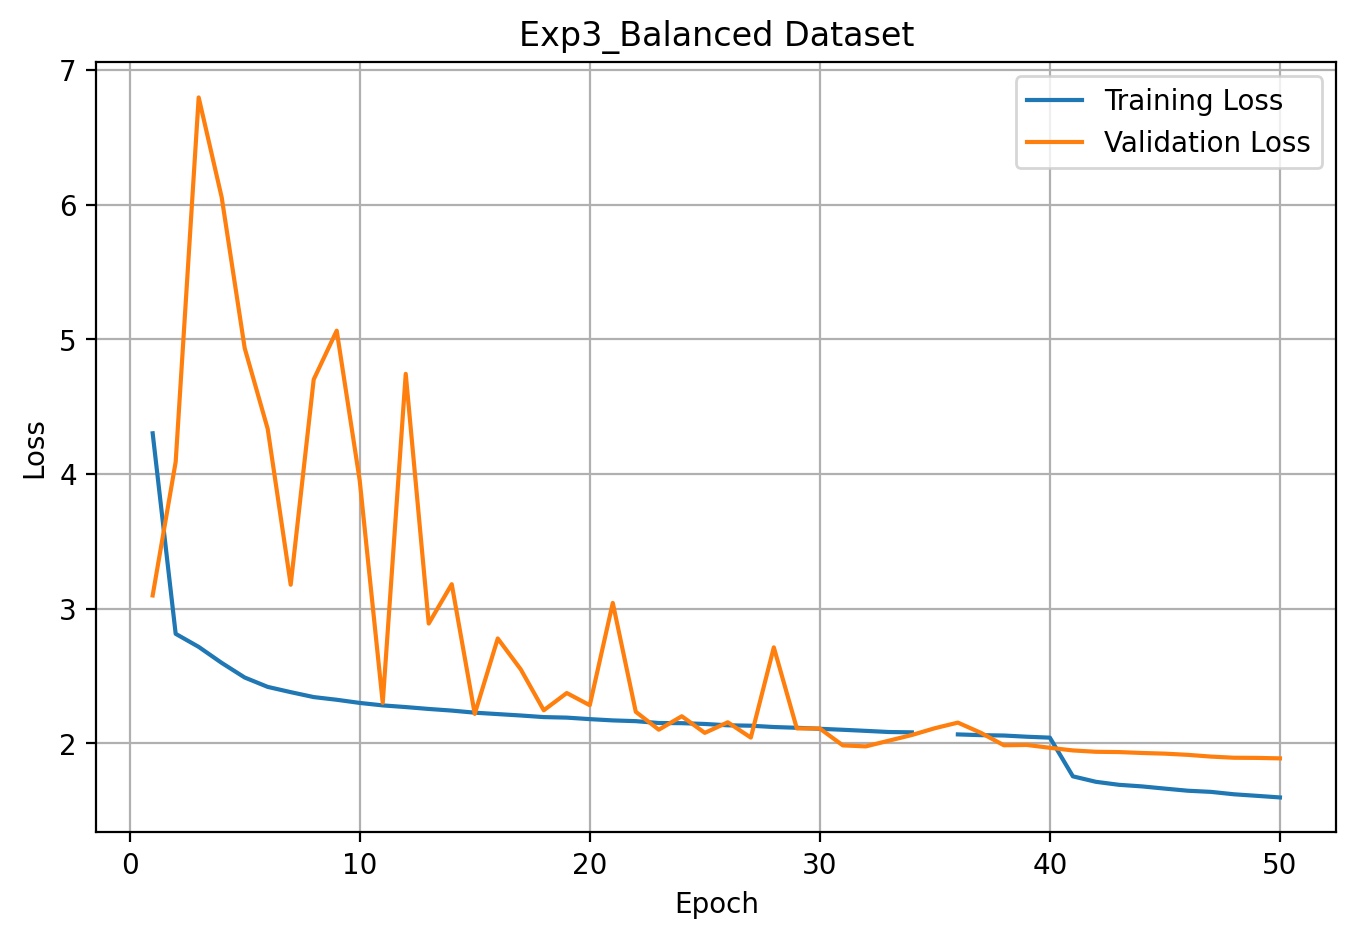

In [ ]:
plot_loss("runs/detect/runs_exp/exp3_balanced", "Exp3_Balanced Dataset")
display(Image("runs/detect/runs_exp/exp3_balanced/loss_curve.png"))

<Figure size 800x500 with 1 Axes>

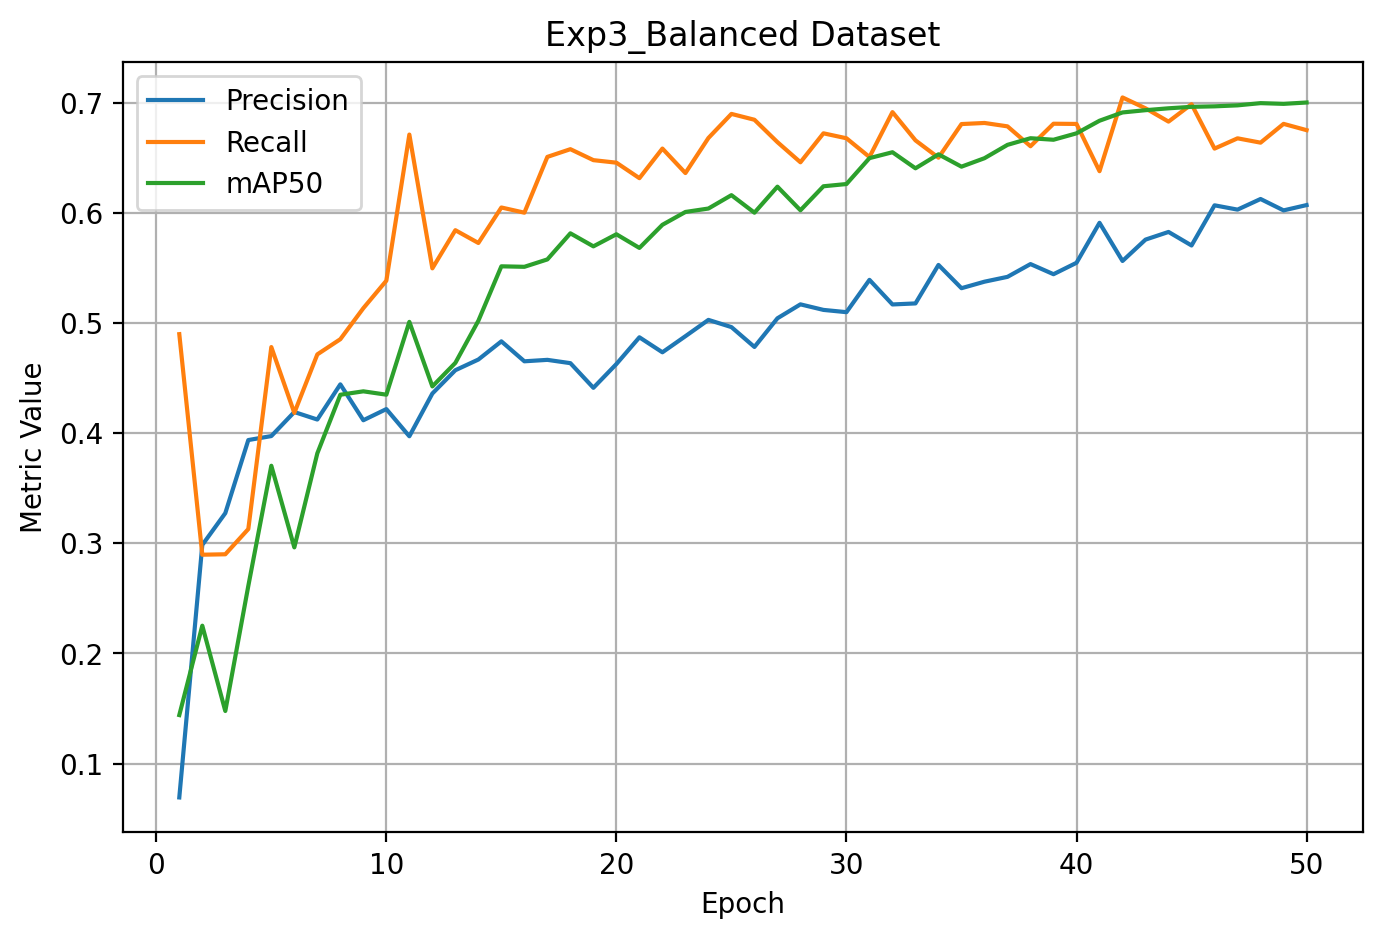

In [ ]:
plot_metrics("runs/detect/runs_exp/exp3_balanced", "Exp3_Balanced Dataset")
display(Image("runs/detect/runs_exp/exp3_balanced/metrics_curve.png"))

Compare all

In [ ]:
!pip install pandas

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.9 MB 7.2 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/9.9 MB 5.1 MB/s eta 0:00:02
   ----------- ---------------------------- 2.9/9.9 MB 4.8 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/9.9 MB 4.4 MB/s eta 0:00:02
   ------------------- -------------------- 4.7/9.9 MB 4.5 MB/s eta 0:00:02
   ---------------------- ----------------- 5.5/9.9 MB 4.6 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.9 MB 4.4 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.9 MB 4.2 MB/s eta 0:00:01
   -------------------------------- ------- 8.1/9.9 MB 4.4 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.9 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.9 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 4.0 MB/s  0:00:02

   ------------------

In [ ]:
import os, glob
import pandas as pd

# ---- Helper: find latest run ----
def latest_run(patterns):
    matches = []
    for p in patterns:
        matches += glob.glob(p, recursive=True)
    matches = [m for m in matches if os.path.isdir(m)]
    if not matches:
        return None
    return max(matches, key=os.path.getmtime)

# ---- Helper: load overall metrics ----
def load_overall_metrics(run_dir):
    csv_path = os.path.join(run_dir, "results.csv")
    if not os.path.exists(csv_path):
        return None

    df = pd.read_csv(csv_path)
    metrics_cols = [c for c in df.columns if c.startswith("metrics/") or c == "fitness"]
    df2 = df[metrics_cols].dropna(how="all")
    if df2.empty:
        return None

    last = df2.iloc[-1].to_dict()
    return last

# ---- Helper: load per-class mAP50 ----
def load_per_class_map(run_dir):
    val_csv = os.path.join(run_dir, "val.csv")
    if not os.path.exists(val_csv):
        return None

    df = pd.read_csv(val_csv)
    if "mAP50" not in df.columns:
        return None

    return df[["class", "mAP50"]]

# ---- Define experiments ----
experiments = {
    "Baseline": ["runs/**/fer_fullbox*"],
    "Exp1_yolo11s": ["runs/**/exp1_yolo11s*"],
    "Exp2_img160": ["runs/**/exp2_img160*"],
    "Exp3_balanced": ["runs/**/exp3_balanced*"]
}

overall_rows = []
per_class_tables = {}

for name, patterns in experiments.items():
    run_dir = latest_run(patterns)
    if run_dir is None:
        overall_rows.append({"Experiment": name, "Status": "NOT FOUND"})
        continue

    # Overall metrics
    m = load_overall_metrics(run_dir)
    if m:
        overall_rows.append({
            "Experiment": name,
            "Precision": round(m.get("metrics/precision(B)", 0), 3),
            "Recall": round(m.get("metrics/recall(B)", 0), 3),
            "mAP50": round(m.get("metrics/mAP50(B)", 0), 3),
            "mAP50-95": round(m.get("metrics/mAP50-95(B)", 0), 3),
            "Fitness": round(m.get("fitness", 0), 3),
            "Status": "OK"
        })

    # Per-class
    pc = load_per_class_map(run_dir)
    if pc is not None:
        per_class_tables[name] = pc.set_index("class")["mAP50"]

# ---- Create overall table ----
overall_df = pd.DataFrame(overall_rows)
print("\n=== Overall Comparison ===")
display(overall_df)




=== Overall Comparison ===


Experiment  Precision  Recall  mAP50  mAP50-95  Fitness Status
0       Baseline      0.554   0.672  0.650     0.650        0     OK
1   Exp1_yolo11s      0.617   0.693  0.711     0.711        0     OK
2    Exp2_img160      0.547   0.644  0.630     0.607        0     OK
3  Exp3_balanced      0.607   0.675  0.700     0.700        0     OK

In [ ]:
from ultralytics import YOLO
import pandas as pd

# -----------------------
# Function to extract metrics
# -----------------------
def get_metrics(model_path, model_name):
    model = YOLO(model_path)
    metrics = model.val(data="dataset_yolo/data.yaml", verbose=False)

    names = metrics.names
    p = metrics.box.p
    r = metrics.box.r
    ap50 = metrics.box.ap50
    ap = metrics.box.ap

    rows = []
    for i, name in names.items():
        rows.append({
            "Model": model_name,
            "Class": name,
            "Precision": float(p[i]),
            "Recall": float(r[i]),
            "mAP50": float(ap50[i]),
            "mAP50-95": float(ap[i]),
            "F1": float(2 * p[i] * r[i] / (p[i] + r[i] + 1e-16))
        })

    return pd.DataFrame(rows)


# -----------------------
# Load All Models
# -----------------------
baseline = get_metrics("runs/detect/runs/fer_fullbox/weights/best.pt", "Baseline")
exp1 = get_metrics("runs/detect/runs_exp/exp1_yolo11s3/weights/best.pt", "YOLO11s")
exp2 = get_metrics("runs/detect/runs_exp/exp2_img160/weights/best.pt", "Img160")
exp3 = get_metrics("runs/detect/runs_exp/exp3_balanced/weights/best.pt", "Balanced")

# -----------------------
# Combine All
# -----------------------
combined_df = pd.concat([baseline, exp1, exp2, exp3])

# Sort nicely
combined_df = combined_df.sort_values(["Class", "Model"])

# Display
print(combined_df)

# Save
combined_df.to_csv("combined_model_comparison.csv", index=False)

print("\nSaved as combined_model_comparison.csv")

Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 101 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 11.21.2 MB/s, size: 1.1 KB)
val: Scanning C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\dataset_yolo\labels\val.cache... 2868 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2868/2868  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 180/180 14.7it/s 12.3s0.1s
                   all       2868       2868      0.544      0.696      0.653      0.653
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to C:\Users\Ace\Desktop\316 lab\218 assignment\New folder\218_Group_project\runs\detect\val10
Ultralytics 8.4.14  Python-3.11.14 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11s summary (fused): 101 l